
# Basic Overview
The objective is to build go through data, validate it and test out linear regression and lasso techniques on the same.

Comments/criticisms/appreciations are greatly accepted and appreciated. Do not be shy and send me an email at babinu@gmail.com !

Source of data : https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../common_routines/')
import numpy as np
from relevant_functions import\
    evaluate_model_score_given_predictions,\
    evaluate_model_score,\
    evaluate_neg_model_score,\
    cross_val_score_given_model,\
    fit_pipeline_and_cross_validate, \
    print_model_stats_from_pipeline, \
    get_validated_transformed_data

In [2]:
complete_train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

In [3]:
len(complete_train_data)

1460

In [4]:
len(complete_train_data.columns)

81

## First things first : Validate the data, before inferring anything !!!

In [5]:
from IPython.display import display

#### Check for nan values

In [6]:
complete_train_data.isnull().values.any()

True

#### Check for total number of null values

In [7]:
num_null_vals = complete_train_data.isnull().values.sum()
print("Total number of null values in training data is {0} ".format(num_null_vals))

Total number of null values in training data is 6965 


In [8]:
(nrow, ncol) = np.shape(complete_train_data)
null_val_percent = num_null_vals * 100.0/(nrow * ncol)
print("Percentage of null values in training data is {0:.2f}".format(null_val_percent))

Percentage of null values in training data is 5.89


#### Drill down on the specific columns having null values.

In [9]:
null_vals_per_col = list(complete_train_data.isnull().values.sum(axis=0))
col_names = list(complete_train_data.columns)
cols_to_num_null_vals = dict(zip(col_names, null_vals_per_col))
for col,num_null_val in cols_to_num_null_vals.items():
    if num_null_val != 0:
        print(col, num_null_val)

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


Comment : Let us remove the entries which have more than 250(~14%) null values.

In [10]:
cols_with_many_null_entries = [col for col in cols_to_num_null_vals.keys() if cols_to_num_null_vals.get(col) > 250]
cols_with_many_null_entries.remove('Fence')
cols_with_many_null_entries.remove('PoolQC')
cols_with_many_null_entries.remove('MiscFeature')
cols_with_many_null_entries.remove('FireplaceQu')



complete_train_data.drop(cols_with_many_null_entries, inplace=True, axis=1)

# Do the same on test data as well since we will not be using this data.

test_data.drop(cols_with_many_null_entries, inplace=True, axis=1)


In [11]:
null_vals_per_col = list(complete_train_data.isnull().values.sum(axis=0))
col_names = list(complete_train_data.columns)
cols_to_num_null_vals = dict(zip(col_names, null_vals_per_col))
for col,num_null_val in cols_to_num_null_vals.items():
    if num_null_val != 0:
        print(col, num_null_val)

MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


### Dealing with missing data.

How do we go about here ? We can either add a flag indicating that the values were missing or not, or we could simply discard these observations. 

For categorical variables, it would be a good idea to add another category named 'missing' for handling observations with nan. This way, we do not simply the information which we have.

We have 2 numeric variables where we have null entries and we add another variable to indicate whether the value was missing or not. 

Thus, we ensure that we do not discard relevant data. This is especially important in this project, as the data size is not very large(only 1460).

#### Dealing with missing values in categorical variables.

In [12]:
def drop_column_both_train_and_test_data(train_data_df, test_data_df, col):
    train_data_df.drop([col], inplace=True, axis=1)            
    test_data_df.drop([col], inplace=True, axis=1)                        


In [13]:
from pandas.api.types import is_numeric_dtype
for col,num_null_val in cols_to_num_null_vals.items():
    if num_null_val != 0:
        if not (is_numeric_dtype(complete_train_data[col])):
            complete_train_data.loc[complete_train_data[col].isnull(), col] = 'Missing'
            test_data.loc[test_data[col].isnull(), col] = 'Missing'            
            
        else:
            complete_train_data[col + '_not_missing'] = complete_train_data[col].notnull()
            test_data[col + '_not_missing'] = test_data[col].notnull()            

            # Replace null values with 0. Note that we can replace it with any value
            # as it will be multiplied by 0
            complete_train_data.loc[complete_train_data[col].isnull(), col] = 0
            test_data.loc[test_data[col].isnull(), col] = 0            
            complete_train_data[col + '_times_not_missing'] = \
                    complete_train_data[col + '_not_missing'] * complete_train_data[col]            

            # Note that same transformations need to be done on the test data as well.
            test_data[col + '_times_not_missing'] = \
                    test_data[col + '_not_missing'] * test_data[col]            
            
            ##drop_column_both_train_and_test_data(complete_train_data, test_data, col)


Comment : Now, that we have reasonably good data to play with, let us proceed to the next step, that is to check if some data transformations could help.

### Data transformations on numeric columns

We go over every relevant numeric column and see whether a data transform could be useful.

In each of the cases , we do the following :

1. Plot data
2. Go over brief data description, that is the mean, standard deviation , quantiles etc.

From these 2, we make a call as to whether it is worthwhile to explore a datatransform or not. 

If the answer turns out to be yes, we do the exact same steps with transformed data as well and then check to see how exactly the data transformation has benefitted us (that is , if there was any benefit).

If we conclude that the data transformation was useful, we proceed with the same and delete the original columns (to avoid presence of redundant data). 

Also, note that once we conclude on transformation, the exact same transformation needs to be performed on test data as well.

For the sake of clarify , I have added analysis for each column as a sub section.

#### Column : Id

In [14]:
complete_train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPo

In [15]:
len(complete_train_data.columns)

83

In [16]:
# We drop Id as that is not useful for prediction.
#drop_column_both_train_and_test_data(complete_train_data, test_data, "Id")


In [17]:
import matplotlib.pyplot as plt
def draw_figure(train_data, column_name):
    fig, axes = plt.subplots(1, 1, figsize=(16, 9))

    (train_data[column_name]).plot(ax=axes)
    axes.set(xlabel='Index of Entries', ylabel=column_name)
    axes.set_title(column_name)

In [18]:
LOG_TRANSFORM = (lambda x : np.log(1.0 + x))

#### Column : MSSubClass

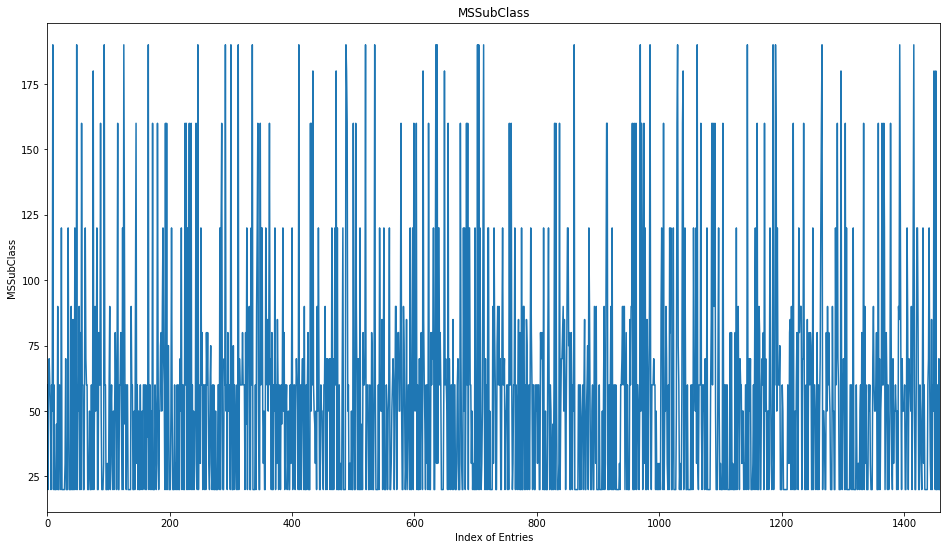

In [19]:
column_name = 'MSSubClass'
draw_figure(complete_train_data, column_name)

In [20]:
complete_train_data[column_name].describe()

count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

Comment : The plot does reveal something that forces us to go back to the drawing board once again. This is actually a discrete variable and it does not make any sense to treat it as a continuous one. 

In [21]:
def apply_transformation_both_train_and_test_data(transformation,
                                                  train_data_df, test_data_df ,
                                                  old_col, new_col):
    train_data_df[new_col] = train_data_df[old_col].apply(transformation)
    test_data_df[new_col] = test_data_df[old_col].apply(transformation)    

In [22]:
apply_transformation_both_train_and_test_data((lambda x : str(x)), complete_train_data, test_data,
                                              'MSSubClass', 'MSSubClass')


In [23]:
complete_train_data['MSSubClass'].describe()

count     1460
unique      15
top         20
freq       536
Name: MSSubClass, dtype: object

#### Column : LotArea

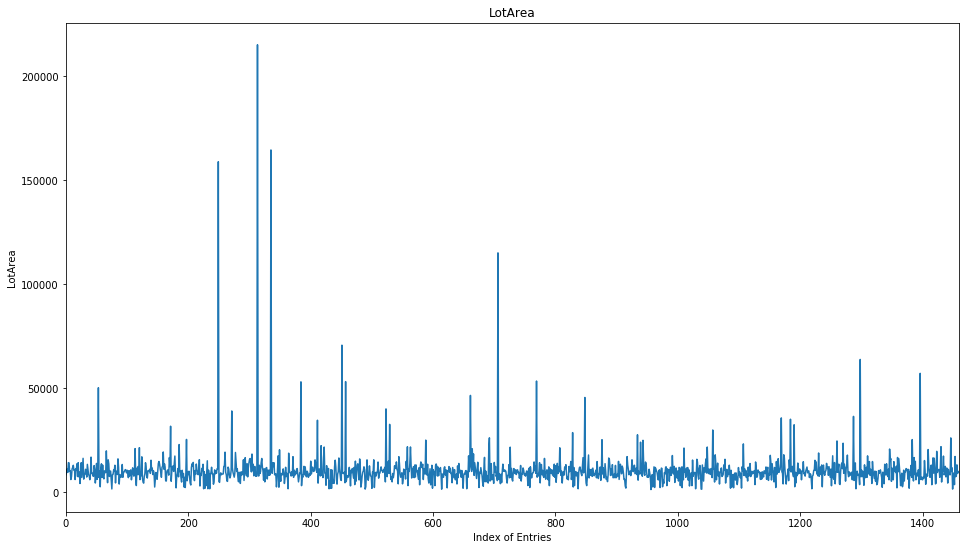

In [24]:
draw_figure(complete_train_data, 'LotArea')

In [25]:
complete_train_data['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Comment : The plot does have some extreme points, and let us see if a log transform would help.

In [26]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM, 
                                              complete_train_data, test_data, 
                                              'LotArea', 'LogLotArea')


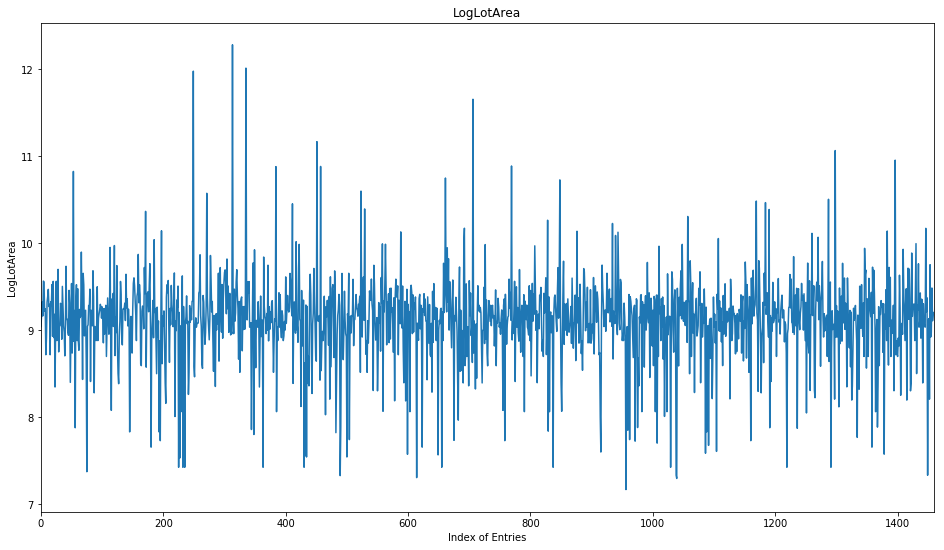

In [27]:
draw_figure(complete_train_data, 'LogLotArea')

In [28]:
complete_train_data['LogLotArea'].describe()

count    1460.000000
mean        9.110966
std         0.517369
min         7.170888
25%         8.929898
50%         9.156887
75%         9.358976
max        12.279537
Name: LogLotArea, dtype: float64

Comment : The distribution looks much more uniform here. Hence, let us stick with the log transform here.

#### Column : OverallQual

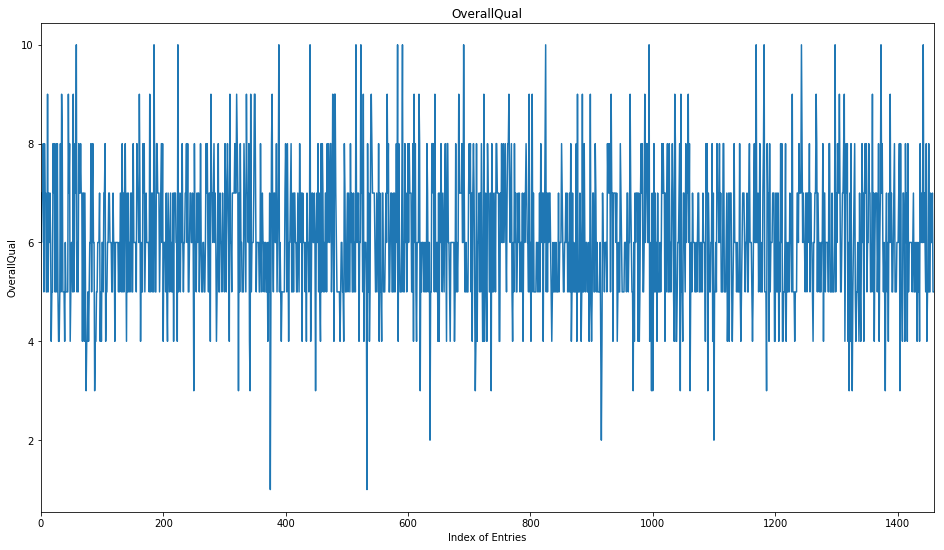

In [29]:

draw_figure(complete_train_data, 'OverallQual')


Comments : As we might expect, this is also a discrete variable and ideally we should be discretizing the same. However, the magnitudes of the variable increase with the increase in quality and hence we should be good with treating it as a continuous variable as well (remember that discretization can increase dimensionality, which is not desirable).

#### Column : OverallCond

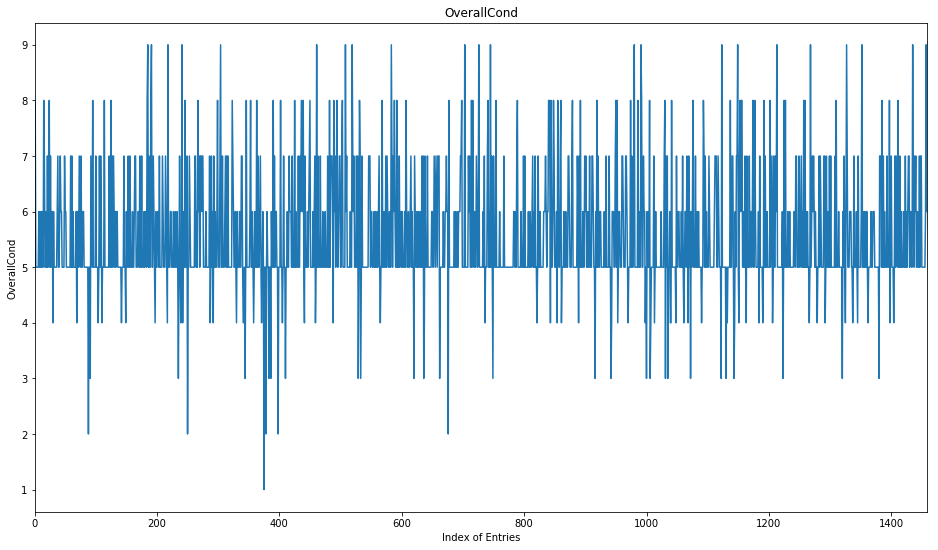

In [30]:
draw_figure(complete_train_data, 'OverallCond')

Comment : The same story as in OverallCond.

#### Column : YearBuilt

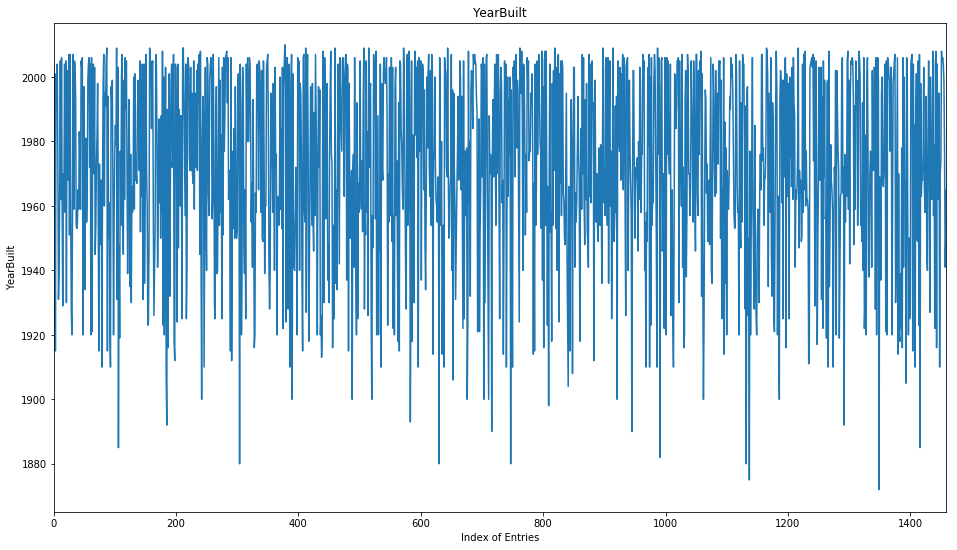

In [31]:
draw_figure(complete_train_data, 'YearBuilt')

Comment : The plot does not necessitate any transform as such.

#### Column : YearRemodAdd

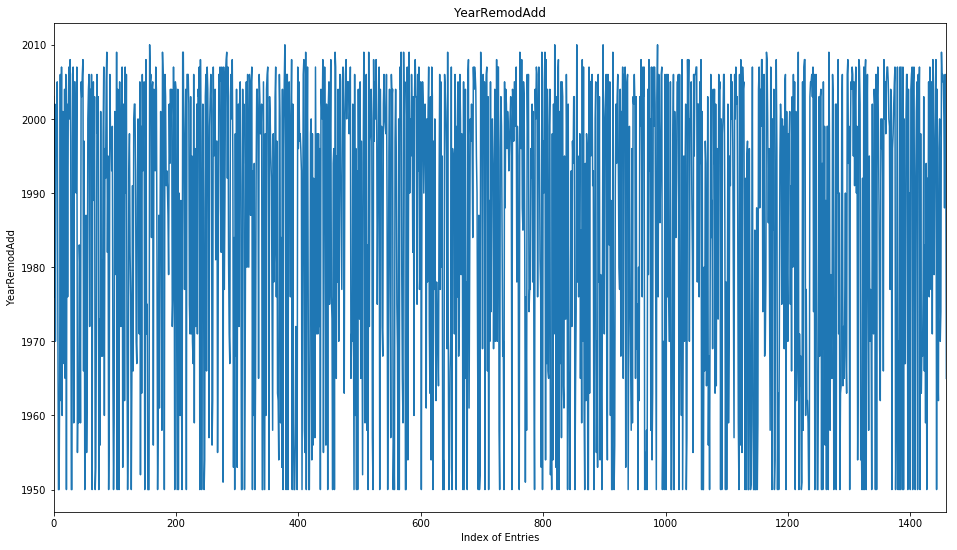

In [32]:
draw_figure(complete_train_data, 'YearRemodAdd')

Comment : Same story

#### Column : BsmtFinSF1

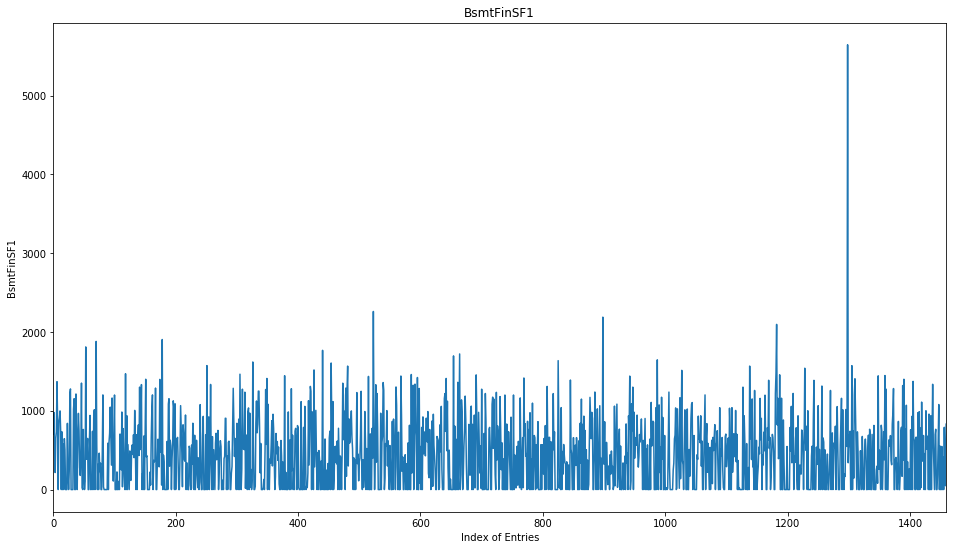

In [33]:
draw_figure(complete_train_data, 'BsmtFinSF1')

In [34]:
complete_train_data['BsmtFinSF1'].describe() 

count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

There looks to be some extreme points. Let us delve on it more !

In [35]:
complete_train_data['BsmtFinSF1'].sort_values(ascending=False).head()

1298    5644
523     2260
898     2188
1182    2096
178     1904
Name: BsmtFinSF1, dtype: int64

Let us see if a log transform would help here.

In [36]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM, 
                                              complete_train_data, test_data, 
                                              'BsmtFinSF1', 'LogBsmtFinSF1')


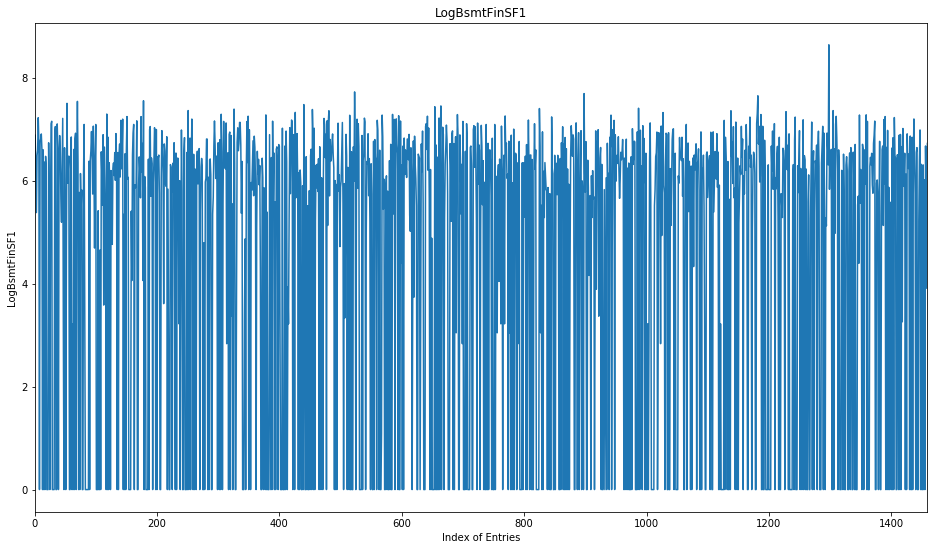

In [37]:
draw_figure(complete_train_data, 'LogBsmtFinSF1')

In [38]:
complete_train_data['LogBsmtFinSF1'].describe()

count    1460.000000
mean        4.229731
std         2.992052
min         0.000000
25%         0.000000
50%         5.951943
75%         6.569832
max         8.638525
Name: LogBsmtFinSF1, dtype: float64

Comment : We look to be having a much more tamed distribution here. Hence, let us stick with the log transform.

In [39]:
(complete_train_data[complete_train_data['BsmtFinSF1'] ==0]['BsmtFinType1']. describe())

count     467
unique      2
top       Unf
freq      430
Name: BsmtFinType1, dtype: object

Comment : We look to be having 467 entries with 0 value for BsmtFinSF1. However 430 of them look to be having 'BsmtFinType1' as 'Unf'(Unfinished) and the rest of them not having data.

In [40]:
complete_train_data[complete_train_data['BsmtFinType1'] =='Unf']['BsmtFinSF1'].describe()

count    430.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: BsmtFinSF1, dtype: float64

Comment : Now, that we have verified that Basement Finish of 'Unf' corresponds to only 0 value of BsmtFinSF1, let us proceed to replace the missing entries with 'Unf'.

In [41]:
complete_train_data.loc[(complete_train_data['BsmtFinType1'] =='Missing'), 'BsmtFinType1'] = 'Unf'
test_data.loc[(test_data['BsmtFinType1'] =='Missing'), 'BsmtFinType1'] = 'Unf'

In [42]:
(complete_train_data[complete_train_data['BsmtFinSF1'] ==0]['BsmtFinType1'].describe())

count     467
unique      1
top       Unf
freq      467
Name: BsmtFinType1, dtype: object

In [43]:
# Should we drop the old, untransformed column or not ?
# We are not dropping it as this might help us in doing data visualizations later on.
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'BsmtFinSF1')

#### Column : BsntFinSF2

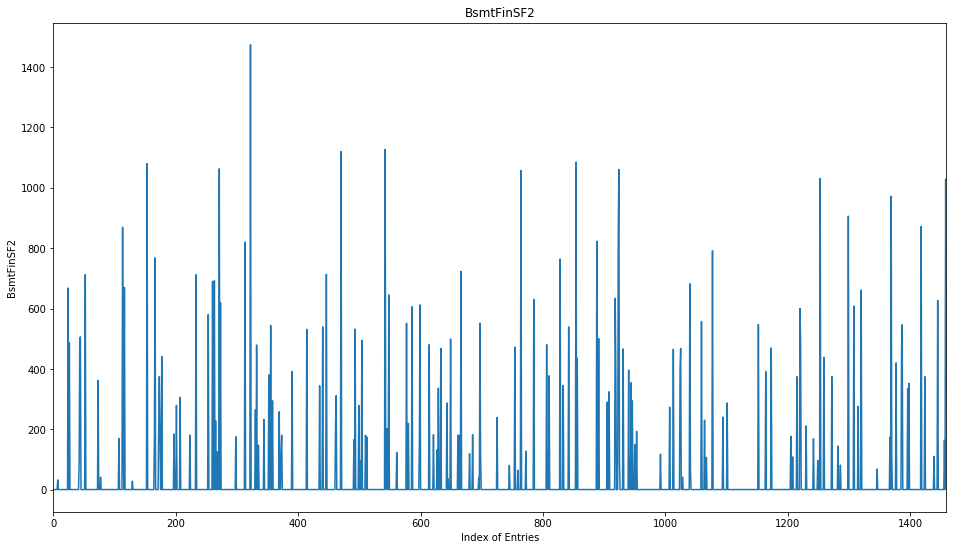

In [44]:
draw_figure(complete_train_data, 'BsmtFinSF2')

In [45]:
complete_train_data['BsmtFinSF2'].describe() 

count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

Comment : The situation looks very similar to that of BsmtFinSF1, with many extreme values. Let us check further 

In [46]:
complete_train_data['BsmtFinSF2'].sort_values(ascending=False).head()

322    1474
542    1127
470    1120
854    1085
153    1080
Name: BsmtFinSF2, dtype: int64

As we saw in the earlier transform situation looks ripe for a log transform. Let us do it !

In [47]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM, 
                                              complete_train_data, test_data, 
                                              'BsmtFinSF2', 'LogBsmtFinSF2')


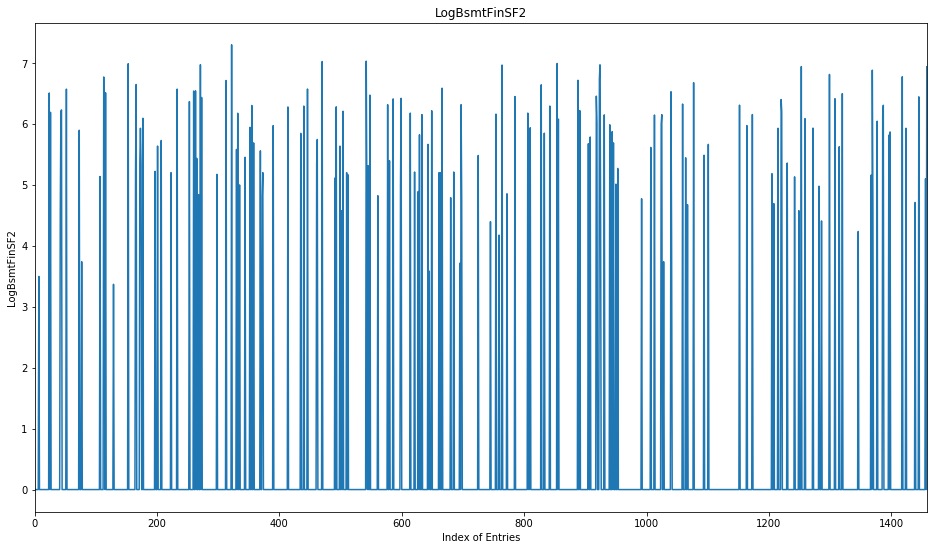

In [48]:
draw_figure(complete_train_data, 'LogBsmtFinSF2')

In [49]:
complete_train_data['LogBsmtFinSF2'].describe() 

count    1460.000000
mean        0.655398
std         1.845045
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.296413
Name: LogBsmtFinSF2, dtype: float64

As we saw earlier, the distribution is much more tame and hence we are sticking with the log transform.

Comment: We look to be having a similar situation here with lots of 0's. Let us see the Basement Finish Type value.

In [50]:
(complete_train_data[complete_train_data['BsmtFinSF2'] ==0]['BsmtFinType2'].describe())

count     1293
unique       2
top        Unf
freq      1256
Name: BsmtFinType2, dtype: object

In [51]:
(complete_train_data[complete_train_data['BsmtFinSF2'] ==0]['BsmtFinType2'].unique())

array(['Unf', 'Missing'], dtype=object)

In [52]:
complete_train_data[complete_train_data['BsmtFinType2'] =='Unf']['BsmtFinSF2'].describe()

count    1256.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: BsmtFinSF2, dtype: float64

Comment : As before ,we let us replace the missing values with 'Unf'.

In [53]:
complete_train_data.loc[(complete_train_data['BsmtFinType2'] =='Missing'), 'BsmtFinType2'] = 'Unf'
test_data.loc[(test_data['BsmtFinType2'] =='Missing'), 'BsmtFinType2'] = 'Unf'

In [54]:
# Should we drop the old, untransformed column or not ?
# We are dropping it as the presence of both untransformed and transformed column could cause confusion later.
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'BsmtFinSF2')

#### Column : BsmtUnfSF

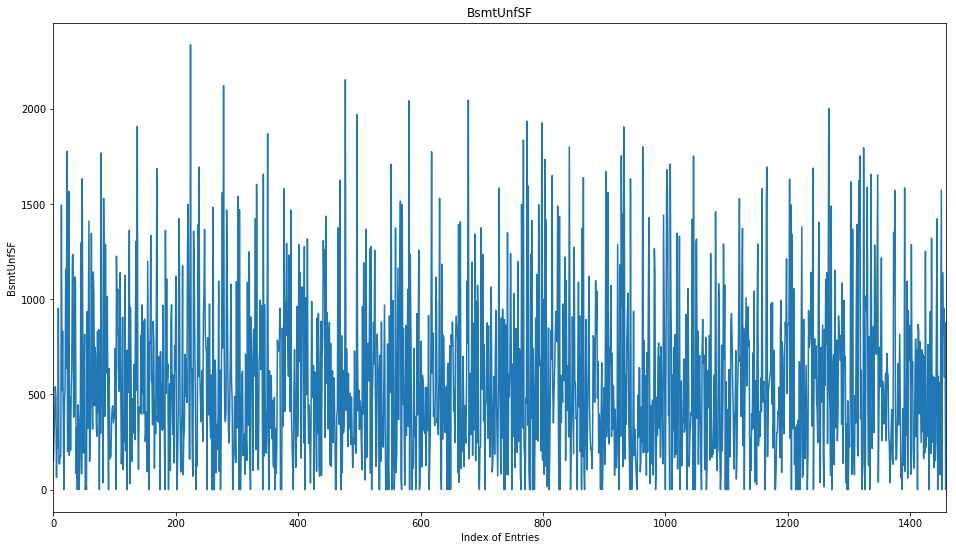

In [55]:
draw_figure(complete_train_data, 'BsmtUnfSF')

In [56]:
complete_train_data['BsmtUnfSF'].describe() 

count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

Let us check some of the extreme values here.

In [57]:
complete_train_data['BsmtUnfSF'].sort_values(ascending=False).head()

224    2336
477    2153
278    2121
678    2046
581    2042
Name: BsmtUnfSF, dtype: int64

Let us check if log transform gives us any benefit or not.

In [58]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM, 
                                              complete_train_data, test_data, 
                                              'BsmtUnfSF', 'LogBsmtUnfSF')


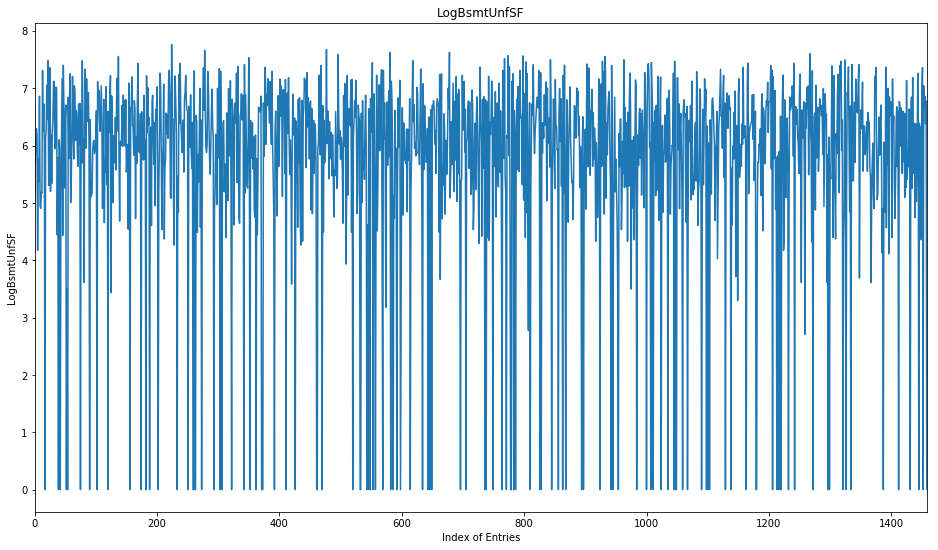

In [59]:
draw_figure(complete_train_data, 'LogBsmtUnfSF')

In [60]:
complete_train_data['LogBsmtUnfSF'].describe()

count    1460.000000
mean        5.648378
std         1.854020
min         0.000000
25%         5.411646
50%         6.170651
75%         6.695799
max         7.756623
Name: LogBsmtUnfSF, dtype: float64

Comment : What do we do here ? We do not see much of a benefit here, because the smaller values tend to be the extremum here.

So, should we go ahead with the transform ? It may not be necessary , but I am still going ahead with it to make things uniform with other basement square feet variables.

However, since we have an element of doubt here, I am not deleting the old column.

#### Column : TotalBsmtSF

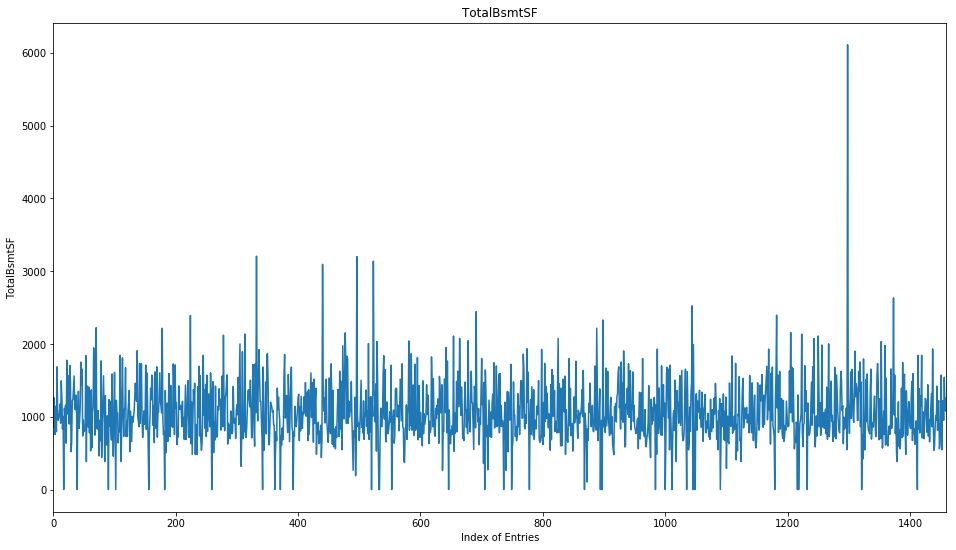

In [61]:
draw_figure(complete_train_data, 'TotalBsmtSF')

In [62]:
complete_train_data['TotalBsmtSF'].describe() 

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [63]:
complete_train_data['TotalBsmtSF'].sort_values(ascending=False).head()

1298    6110
332     3206
496     3200
523     3138
440     3094
Name: TotalBsmtSF, dtype: int64

Comment : This looks like an easy pick for a log transformation.

In [64]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM, 
                                              complete_train_data, test_data, 
                                              'TotalBsmtSF', 'LogTotalBsmtSF')


In [65]:
len(complete_train_data[complete_train_data['TotalBsmtSF'] == 0])

37

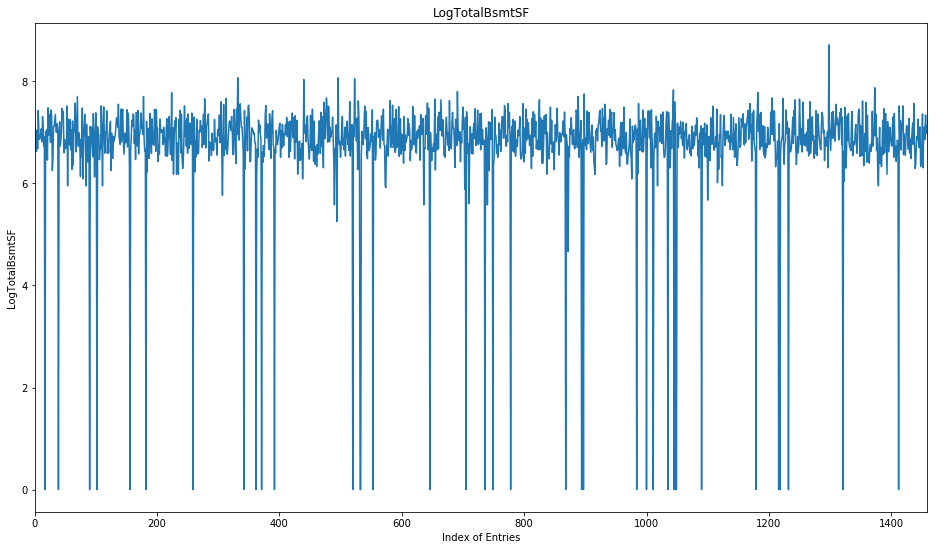

In [66]:
draw_figure(complete_train_data, 'LogTotalBsmtSF')

In [67]:
complete_train_data['LogTotalBsmtSF'].describe()

count    1460.000000
mean        6.750560
std         1.145712
min         0.000000
25%         6.680541
50%         6.900227
75%         7.169542
max         8.717846
Name: LogTotalBsmtSF, dtype: float64

In [68]:
complete_train_data['LogTotalBsmtSF'].sort_values().head(38)

646     0.000000
1035    0.000000
392     0.000000
749     0.000000
1011    0.000000
868     0.000000
1000    0.000000
371     0.000000
778     0.000000
342     0.000000
102     0.000000
984     0.000000
39      0.000000
894     0.000000
362     0.000000
705     0.000000
259     0.000000
90      0.000000
736     0.000000
1321    0.000000
1232    0.000000
1045    0.000000
897     0.000000
1090    0.000000
182     0.000000
520     0.000000
1216    0.000000
1218    0.000000
532     0.000000
1049    0.000000
533     0.000000
1179    0.000000
17      0.000000
1048    0.000000
553     0.000000
1412    0.000000
156     0.000000
872     4.663439
Name: LogTotalBsmtSF, dtype: float64

Comment : This is a similar story as before, but let us stick with the log transform so that the varible goes in tandem with the related ones.

However, since we have an element of doubt here, I am not deleting the old column.


#### Column : 1stFlrSF

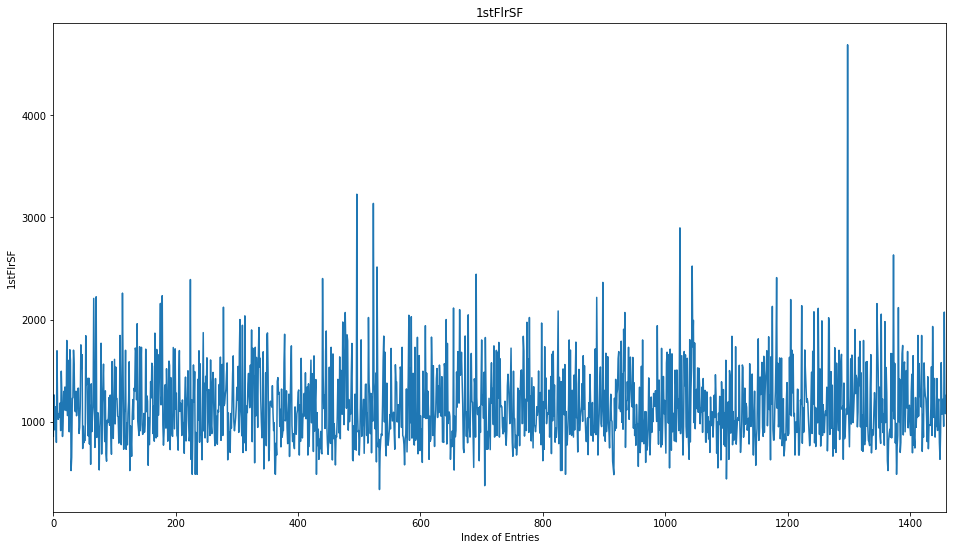

In [69]:
draw_figure(complete_train_data, '1stFlrSF')

In [70]:
complete_train_data['1stFlrSF'].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

In [71]:
complete_train_data['1stFlrSF'].sort_values(ascending=True).head()

533     334
705     372
1100    438
916     480
430     483
Name: 1stFlrSF, dtype: int64

In [72]:
complete_train_data['1stFlrSF'].sort_values(ascending=False).head()

1298    4692
496     3228
523     3138
1024    2898
1373    2633
Name: 1stFlrSF, dtype: int64

Comment : Looks ideal for a log transformation.

In [73]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM, 
                                              complete_train_data, test_data, 
                                              '1stFlrSF', 'Log1stFlrSF')


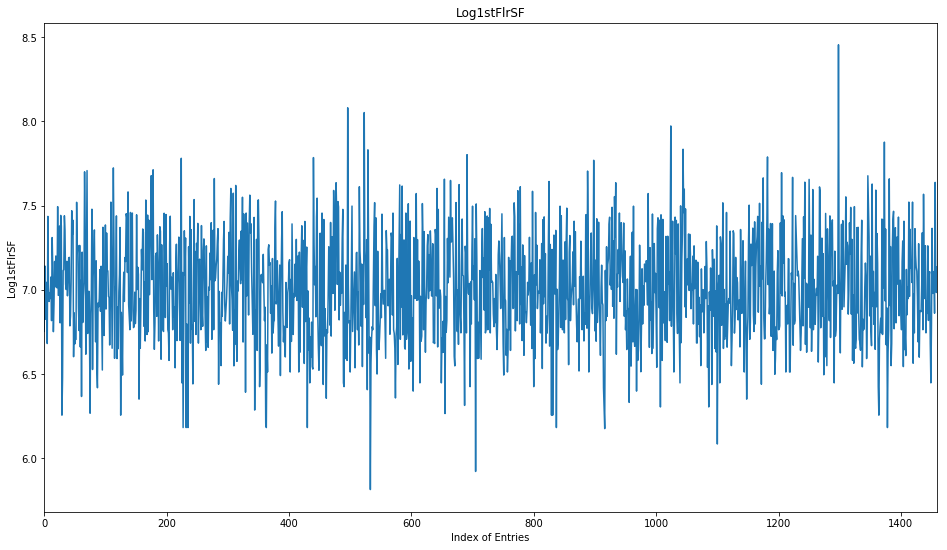

In [74]:
draw_figure(complete_train_data, 'Log1stFlrSF')

In [75]:
complete_train_data['Log1stFlrSF'].describe()

count    1460.000000
mean        7.008452
std         0.317431
min         5.814131
25%         6.783325
50%         6.992096
75%         7.238676
max         8.453827
Name: Log1stFlrSF, dtype: float64

Comment : The distribution appears a lot more tamed here. Hence, we ahead with the transform.

In [76]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, '1stFlrSF')


#### Column : 2ndFlrSF

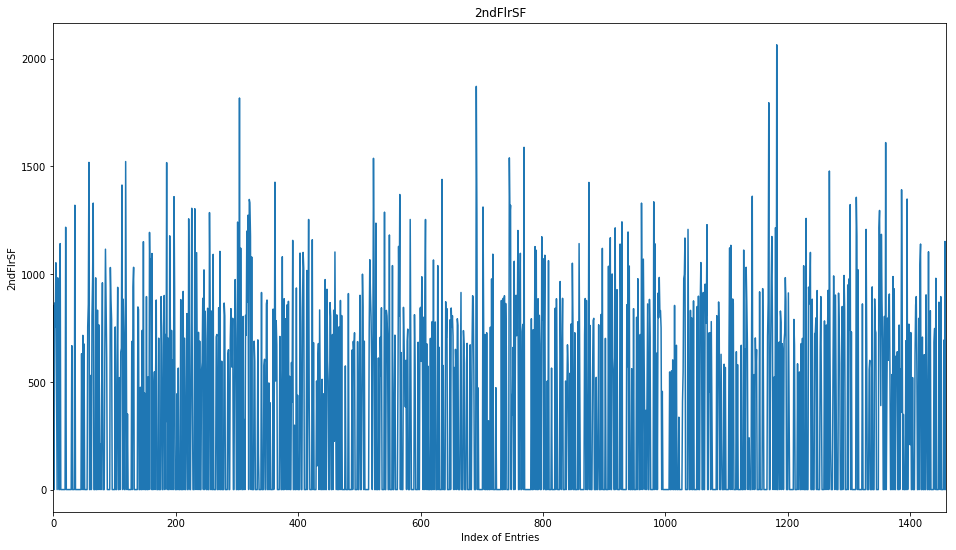

In [77]:
draw_figure(complete_train_data, '2ndFlrSF')

In [78]:
complete_train_data['2ndFlrSF'].describe() 

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

In [79]:
complete_train_data['2ndFlrSF'].sort_values(ascending=False).head()

1182    2065
691     1872
304     1818
1169    1796
1360    1611
Name: 2ndFlrSF, dtype: int64

In [80]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                             '2ndFlrSF', 'Log2ndFlrSF')

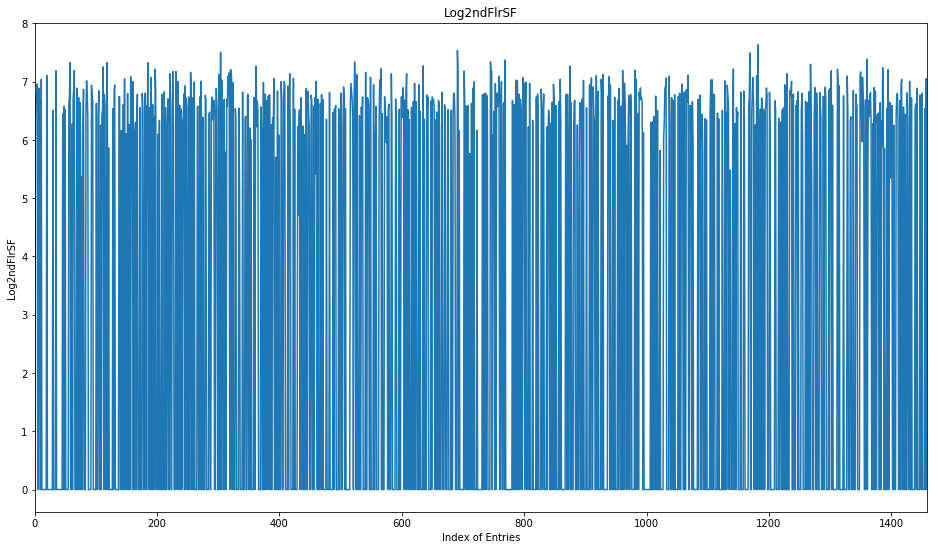

In [81]:
draw_figure(complete_train_data, 'Log2ndFlrSF')

In [82]:
complete_train_data['Log2ndFlrSF'].describe()

count    1460.000000
mean        2.864586
std         3.293311
min         0.000000
25%         0.000000
50%         0.000000
75%         6.591674
max         7.633370
Name: Log2ndFlrSF, dtype: float64

Comment: The extreme values have been shrunk and this is a good sign.

In [83]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, '2ndFlrSF')

#### Column : LowQualFinSF

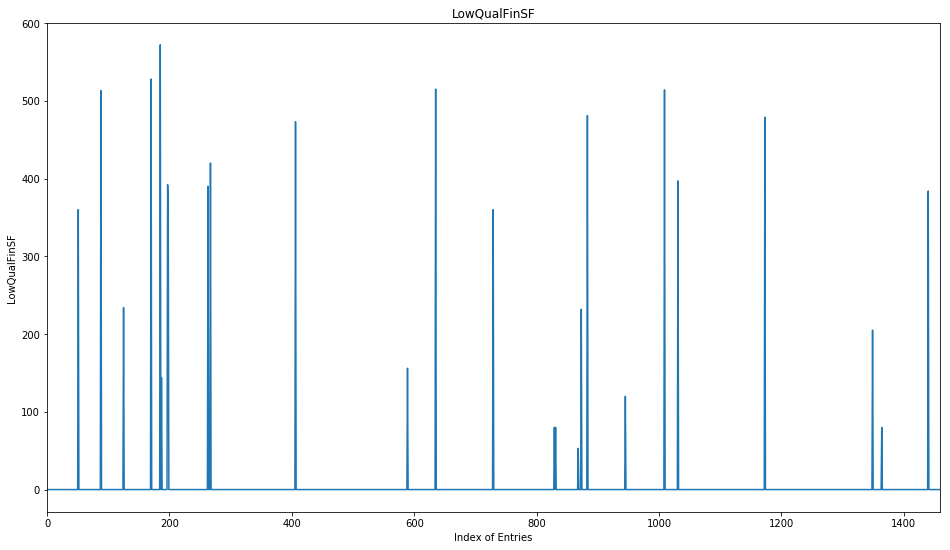

In [84]:
draw_figure(complete_train_data, 'LowQualFinSF')

In [85]:
complete_train_data['LowQualFinSF'].describe() 

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

In [86]:
complete_train_data['LowQualFinSF'].sort_values(ascending=False).head(20) 

185     572
170     528
635     515
1009    514
88      513
883     481
1173    479
406     473
267     420
1031    397
197     392
263     390
1440    384
198     371
51      360
729     360
125     234
873     232
1349    205
589     156
Name: LowQualFinSF, dtype: int64

Comment : Looks like an ideal candidate for log transform. Let us do it !

In [87]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                               complete_train_data, test_data,
                                              'LowQualFinSF', 'LogLowQualFinSF')

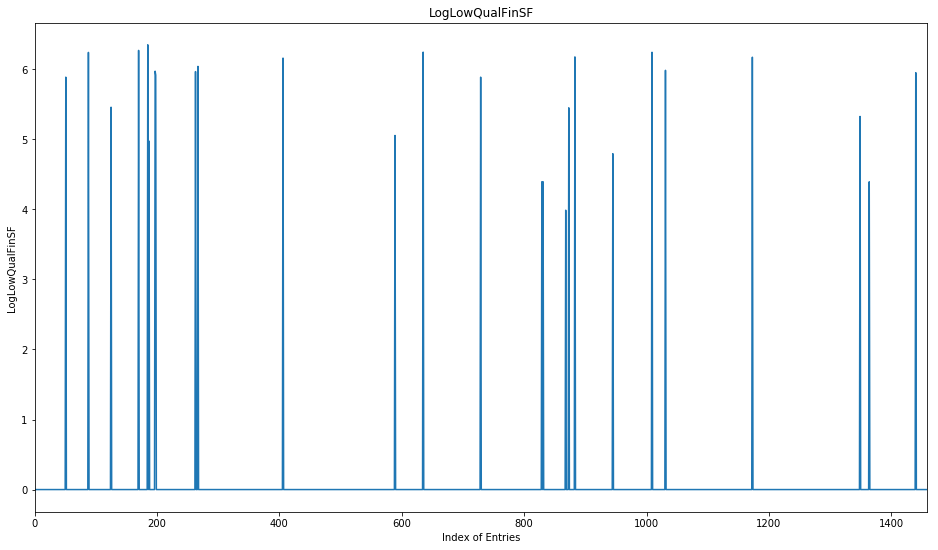

In [88]:
draw_figure(complete_train_data, 'LogLowQualFinSF') 

In [89]:
complete_train_data['LogLowQualFinSF'].describe()

count    1460.000000
mean        0.099814
std         0.747354
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.350886
Name: LogLowQualFinSF, dtype: float64

In [90]:
complete_train_data['LogLowQualFinSF'].sort_values(ascending=False).head(20)

185     6.350886
170     6.270988
635     6.246107
1009    6.244167
88      6.242223
883     6.177944
1173    6.173786
406     6.161207
267     6.042633
1031    5.986452
197     5.973810
263     5.968708
1440    5.953243
198     5.918894
51      5.888878
729     5.888878
125     5.459586
873     5.451038
1349    5.327876
589     5.056246
Name: LogLowQualFinSF, dtype: float64


Comment : Does not look to show much benefit, but I am still including a log transform to make sure that all basement related variables are consistent. However, since we have an element of doubt here, I am not deleting the old column.

#### Summary regarding room area variables.

We just finished exploring  data transformations to all the relevant room variables. We did note that log transform did not yield much of benefit for the following 3 variables(for others, there was remarkable benefit to using the log transform) :

(a) LowQualFinSF

(b) BsmtUnfSF

(c) TotalBsmtSF

As we saw earlier, we still applied log transformations to these variables to keep them consistent with the rest. However, I have deleted the old column ( as we did in other transforms), to make sure that we could switch to the same if we found it necessary.


#### Column : GrLivArea

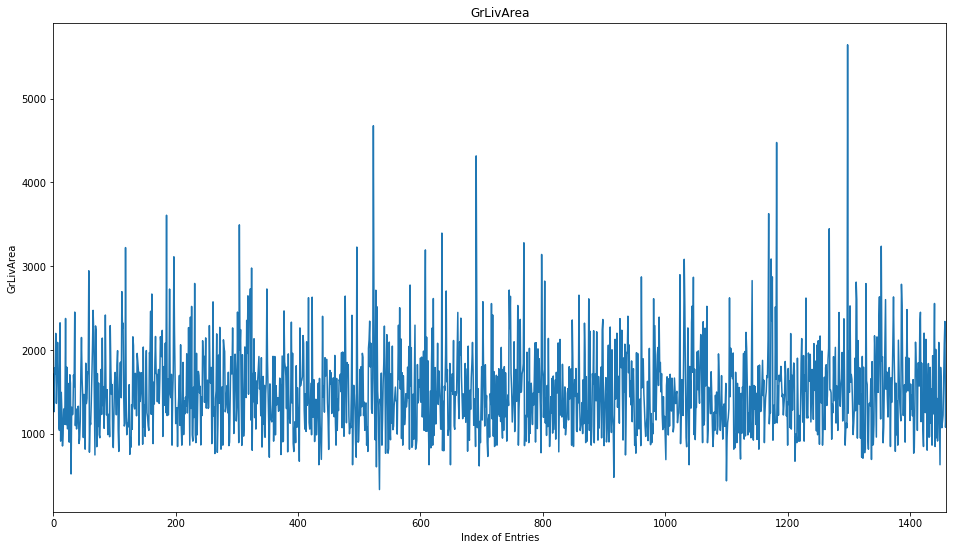

In [91]:
draw_figure(complete_train_data, 'GrLivArea')

Comments : Few extremums, but still worth look at a log transform.

In [92]:
complete_train_data['GrLivArea'].describe() 

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

Comment : This looks like an ideal candidate for a log transform as it can rein in extreme values.

In [93]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'GrLivArea', 'LogGrLivArea')

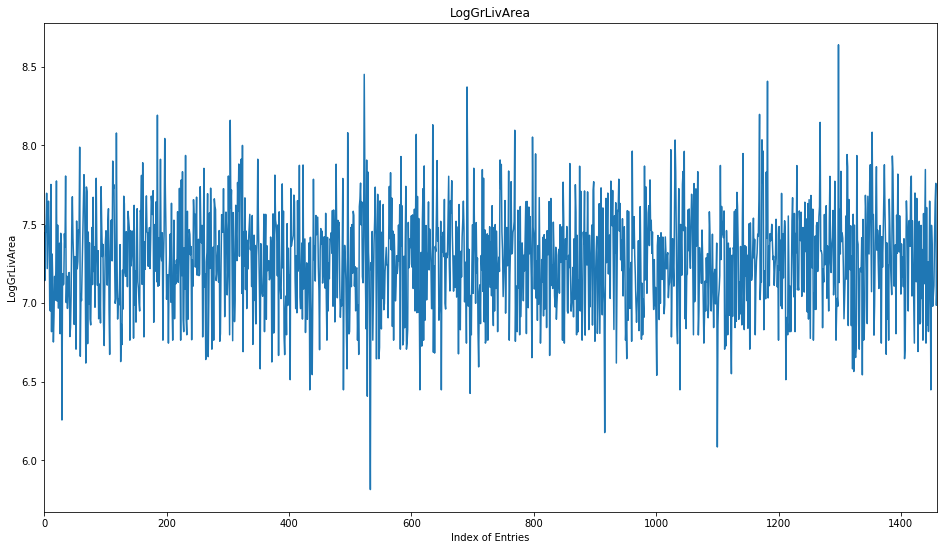

In [94]:
draw_figure(complete_train_data, 'LogGrLivArea')

In [95]:
complete_train_data['LogGrLivArea'].describe()

count    1460.000000
mean        7.268512
std         0.333303
min         5.814131
25%         7.030415
50%         7.289611
75%         7.483104
max         8.638171
Name: LogGrLivArea, dtype: float64

Comment : We look to have reduced the effect of few extreme points, so let us stick on with this.

In [96]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'GrLivArea')

#### Columns showing the number of bathrooms : BsmtFullBath, BsmtHalfBath, FullBath, HalfBath

In [97]:
complete_train_data['BsmtFullBath'].unique() 

array([1, 0, 2, 3])

In [98]:
complete_train_data['BsmtHalfBath'].unique() 

array([0, 1, 2])

In [99]:
complete_train_data['FullBath'].unique() 

array([2, 1, 3, 0])

In [100]:
complete_train_data['HalfBath'].unique() 

array([1, 0, 2])

Comments : These do not warrant a transform as these are essentailly discrete variables. However, since these represent a count measure, we do not need to treat them as categorical variables.

#### Columns showing the number of rooms : BedroomAbvGr, KitchenAbvGr, Fireplaces, GarageCars

In [101]:
complete_train_data['BedroomAbvGr'].unique() 

array([3, 4, 1, 2, 0, 5, 6, 8])

In [102]:
complete_train_data['KitchenAbvGr'].unique() 

array([1, 2, 3, 0])

In [103]:
complete_train_data['TotRmsAbvGrd'].unique() 

array([ 8,  6,  7,  9,  5, 11,  4, 10, 12,  3,  2, 14])

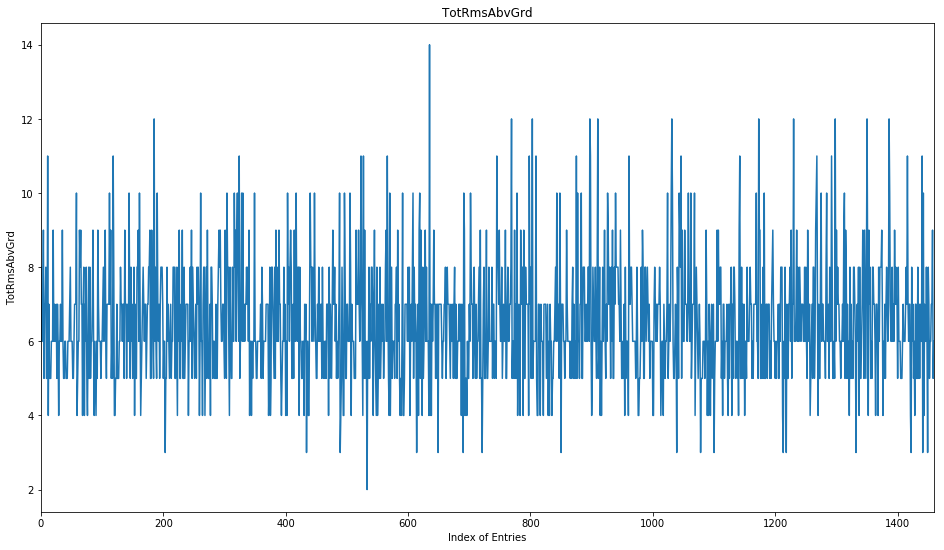

In [104]:
draw_figure(complete_train_data,  'TotRmsAbvGrd')

In [105]:
complete_train_data['Fireplaces'].unique() 

array([0, 1, 2, 3])

In [106]:
complete_train_data['GarageCars'].unique() 

array([2, 3, 1, 0, 4])

Comment : We have the same story as in the earlier section

#### Column : GarageArea

In [107]:
complete_train_data['GarageArea'].unique() 

array([ 548,  460,  608,  642,  836,  480,  636,  484,  468,  205,  384,
        736,  352,  840,  576,  516,  294,  853,  280,  534,  572,  270,
        890,  772,  319,  240,  250,  271,  447,  556,  691,  672,  498,
        246,    0,  440,  308,  504,  300,  670,  826,  386,  388,  528,
        894,  565,  641,  288,  645,  852,  558,  220,  667,  360,  427,
        490,  379,  297,  283,  509,  405,  758,  461,  400,  462,  420,
        432,  506,  684,  472,  366,  476,  410,  740,  648,  273,  546,
        325,  792,  450,  180,  430,  594,  390,  540,  264,  530,  435,
        453,  750,  487,  624,  471,  318,  766,  660,  470,  720,  577,
        380,  434,  866,  495,  564,  312,  625,  680,  678,  726,  532,
        216,  303,  789,  511,  616,  521,  451, 1166,  252,  497,  682,
        666,  786,  795,  856,  473,  398,  500,  349,  454,  644,  299,
        210,  431,  438,  675,  968,  721,  336,  810,  494,  457,  818,
        463,  604,  389,  538,  520,  309,  429,  6

In [108]:
len(complete_train_data['GarageArea'].unique())

441

In [109]:
complete_train_data['GarageArea'].describe() 

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

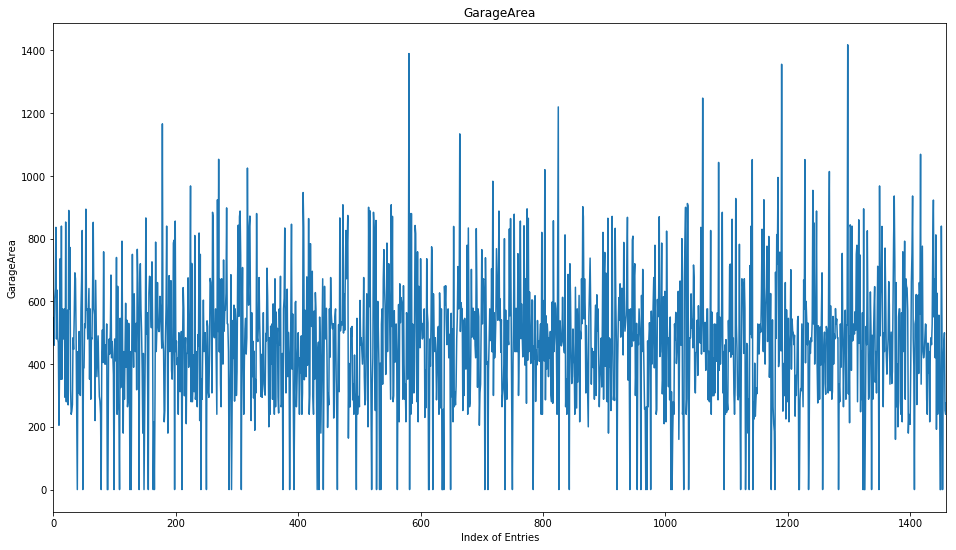

In [110]:
draw_figure(complete_train_data, 'GarageArea')

Comment : Some extreme values, but let us see if a log transform would help.

In [111]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'GarageArea', 'LogGarageArea')


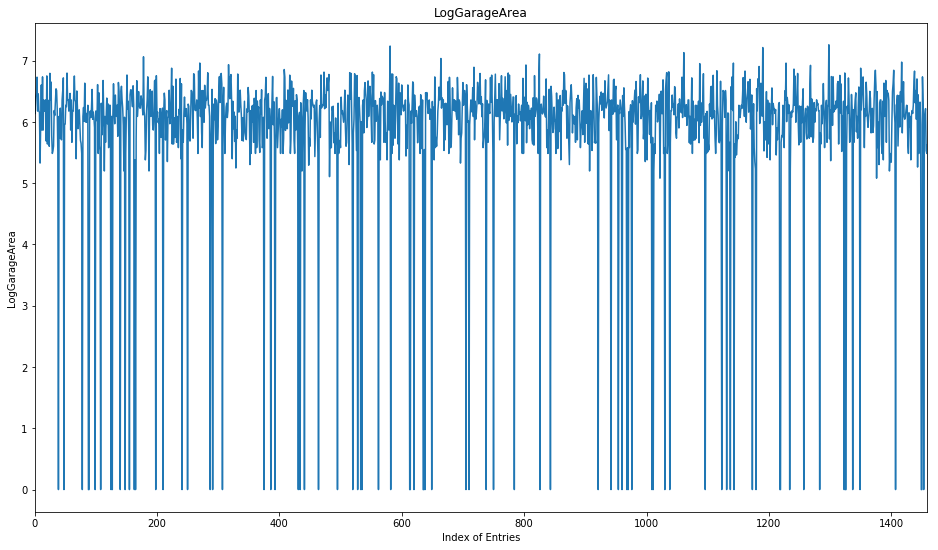

In [112]:
draw_figure(complete_train_data, 'LogGarageArea')

In [113]:
complete_train_data['LogGarageArea'].describe()

count    1460.000000
mean        5.808156
std         1.455118
min         0.000000
25%         5.815592
50%         6.175867
75%         6.357842
max         7.257708
Name: LogGarageArea, dtype: float64

In [114]:
complete_train_data['LogGarageArea'].sort_values().head(100)

1219    0.000000
649     0.000000
210     0.000000
1131    0.000000
1123    0.000000
78      0.000000
140     0.000000
1323    0.000000
1218    0.000000
148     0.000000
1137    0.000000
705     0.000000
710     0.000000
1096    0.000000
1349    0.000000
155     0.000000
750     0.000000
1325    0.000000
784     0.000000
1283    0.000000
1038    0.000000
495     0.000000
88      0.000000
89      0.000000
1143    0.000000
1179    0.000000
307     0.000000
1173    0.000000
582     0.000000
125     0.000000
          ...   
960     0.000000
441     0.000000
1011    0.000000
562     0.000000
39      0.000000
826     0.000000
1234    0.000000
198     0.000000
165     0.000000
163     0.000000
843     0.000000
1022    5.081404
1376    5.081404
482     5.105945
907     5.198497
146     5.198497
1235    5.198497
187     5.198497
1397    5.198497
114     5.198497
437     5.198497
1012    5.198497
1135    5.198497
1178    5.231109
329     5.247024
1443    5.262690
448     5.293305
352     5.3033

Comment : The zero becomes an extreme values in the resulting log distribution, but otherwise the transformation does look to give us some benefit in reining in extreme values.

Taking a step back, does the value of 0 make sense ? In fact if one were to look earlier , the exact same issue was observed for LowQualFinSF, BsmtUnfSF and TotalBsmtSF variables as well.

Let us stick with the log transform for these variables for now, but let us keep this issue about 0 values in our mind. We may need to add another indicator variable to indicate that the variable is non zero before using it in our model. Since we have slight hesitation here, I am not deleting the original column.

In [115]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'GarageArea')


#### Column : WoodDeckSF

In [116]:
len(complete_train_data['WoodDeckSF'].unique())

274

In [117]:
complete_train_data['WoodDeckSF'].describe()

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

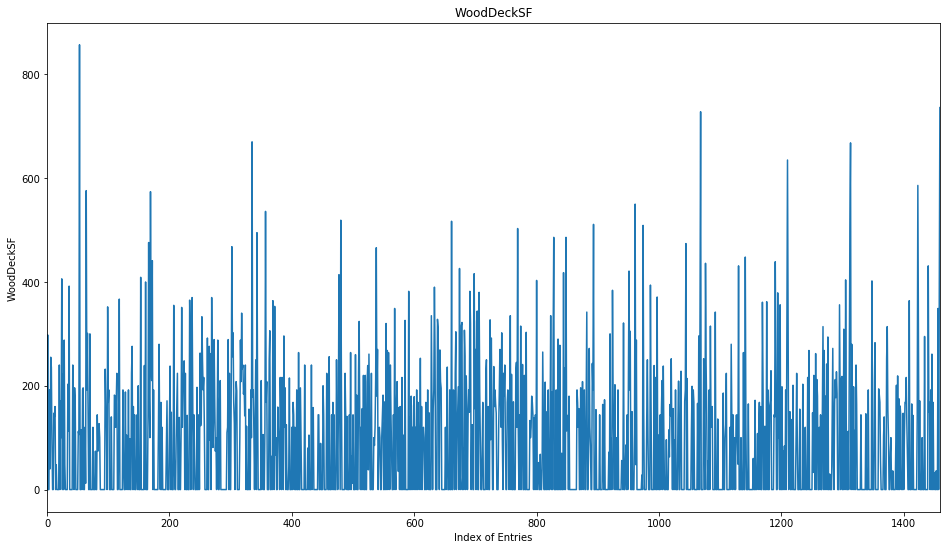

In [118]:
draw_figure(complete_train_data, 'WoodDeckSF')

In [119]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'WoodDeckSF', 'LogWoodDeckSF')


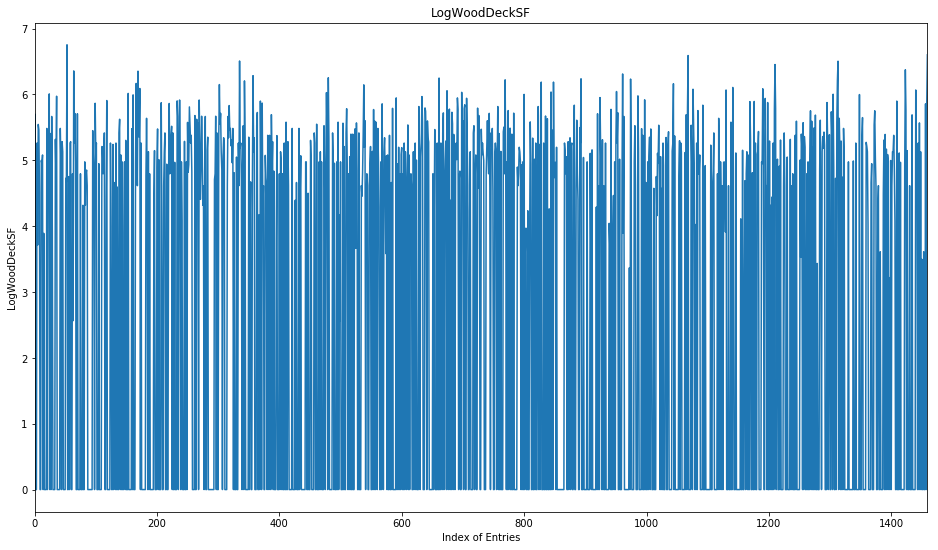

In [120]:
draw_figure(complete_train_data, 'LogWoodDeckSF')

In [121]:
complete_train_data['LogWoodDeckSF'].describe()

count    1460.000000
mean        2.457206
std         2.596435
min         0.000000
25%         0.000000
50%         0.000000
75%         5.129899
max         6.754604
Name: LogWoodDeckSF, dtype: float64

Comment: It looks like we have reined in the extreme values. Hence, let us stick with the transform.

In [122]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'WoodDeckSF')


#### Column : OpenPorchSF

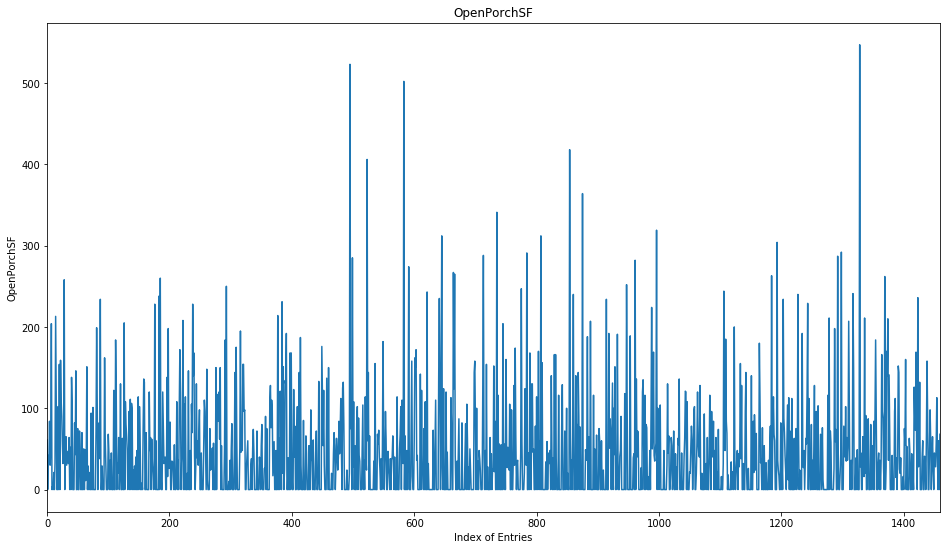

In [123]:
draw_figure(complete_train_data, 'OpenPorchSF')

In [124]:
len(complete_train_data['OpenPorchSF'].unique())

202

In [125]:
complete_train_data['OpenPorchSF'].describe()

count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

In [126]:
complete_train_data['OpenPorchSF'].sort_values(ascending=False).head()

1328    547
495     523
583     502
854     418
523     406
Name: OpenPorchSF, dtype: int64

Comment : Looks like an ideal candidate for a log transform for reining in extremely large values.

In [127]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'OpenPorchSF', 'LogOpenPorchSF')

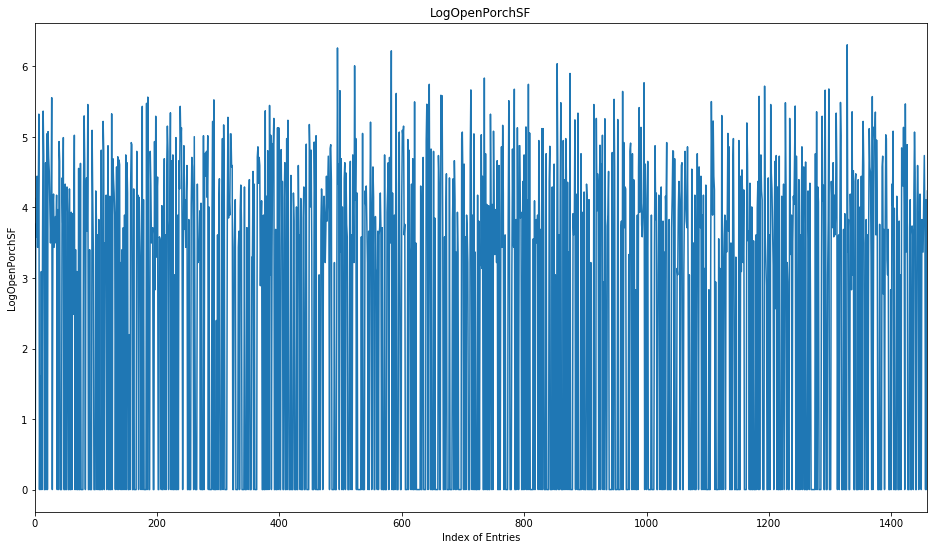

In [128]:
draw_figure(complete_train_data, 'LogOpenPorchSF')

In [129]:
complete_train_data['LogOpenPorchSF'].describe()

count    1460.000000
mean        2.308541
std         2.152387
min         0.000000
25%         0.000000
50%         3.258097
75%         4.234107
max         6.306275
Name: LogOpenPorchSF, dtype: float64

Comment : Looks like a great fit and we are proceeding with the log transform.

In [130]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'OpenPorchSF')


#### Column : EnclosedPorch

In [131]:
complete_train_data['EnclosedPorch'].unique()

array([  0, 272, 228, 205, 176,  87, 172, 102,  37, 144,  64, 114, 202,
       128, 156,  44,  77, 192, 140, 180, 183,  39, 184,  40, 552,  30,
       126,  96,  60, 150, 120, 112, 252,  52, 224, 234, 244, 268, 137,
        24, 108, 294, 177, 218, 242,  91, 160, 130, 169, 105,  34, 248,
       236,  32,  80, 115, 291, 116, 158, 210,  36, 200,  84, 148, 136,
       240,  54, 100, 189, 293, 164, 216, 239,  67,  90,  56, 129,  98,
       143,  70, 386, 154, 185, 134, 196, 264, 275, 230, 254,  68, 194,
       318,  48,  94, 138, 226, 174,  19, 170, 220, 214, 280, 190, 330,
       208, 145, 259,  81,  42, 123, 162, 286, 168,  20, 301, 198, 221,
       212,  50,  99])

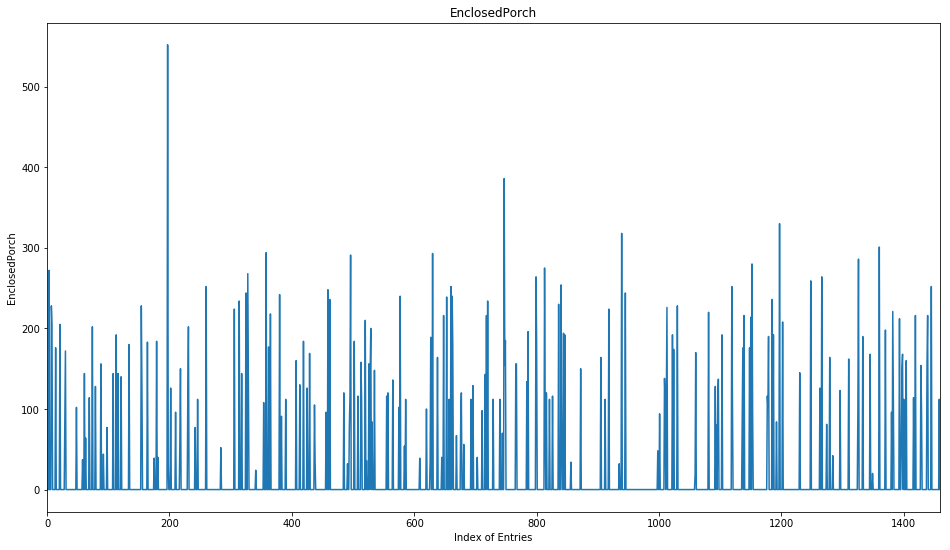

In [132]:
draw_figure(complete_train_data, 'EnclosedPorch')

In [133]:
complete_train_data['EnclosedPorch'].describe()

count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

Comment : Looks great for a log transform.

In [134]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'EnclosedPorch', 'LogEnclosedPorch')

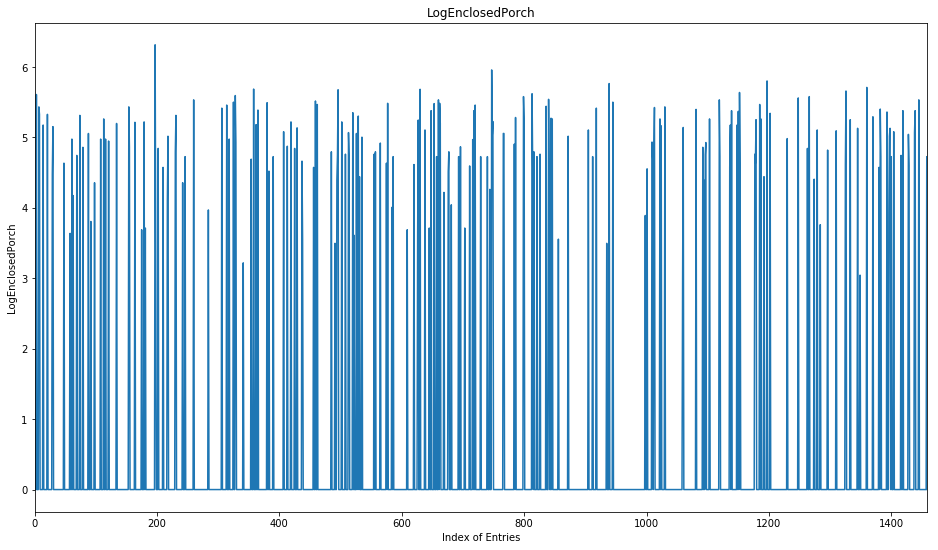

In [135]:
draw_figure(complete_train_data, 'LogEnclosedPorch')

In [136]:
complete_train_data['LogEnclosedPorch'].describe()

count    1460.000000
mean        0.698019
std         1.727317
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.315358
Name: LogEnclosedPorch, dtype: float64

Comment : As in the previous case, we are keeping the log transform.

In [137]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'EnclosedPorch')

#### Column : 3SsnPorch

In [138]:
complete_train_data['3SsnPorch'].unique()

array([  0, 320, 407, 130, 180, 168, 140, 508, 238, 245, 196, 144, 182,
       162,  23, 216,  96, 153, 290, 304])

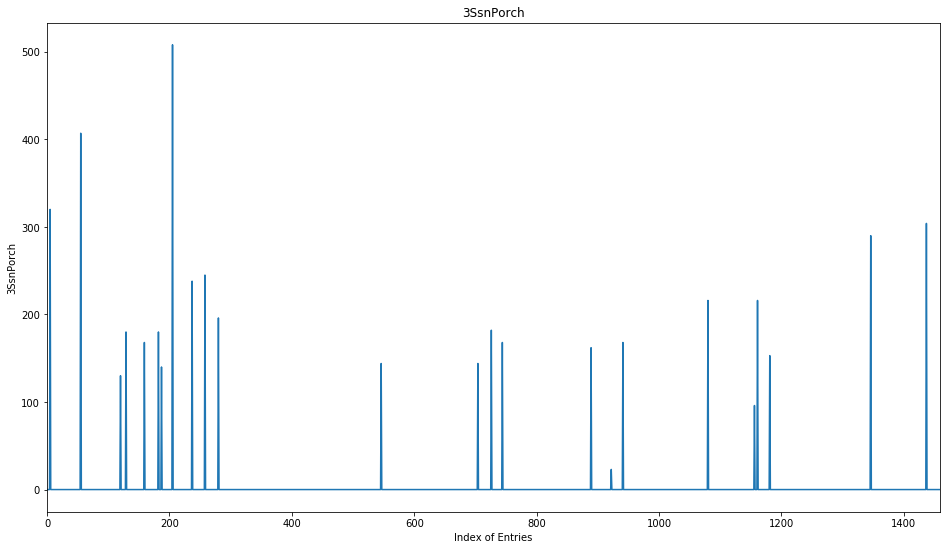

In [139]:
draw_figure(complete_train_data, '3SsnPorch')

In [140]:
complete_train_data['3SsnPorch'].describe()

count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

In [141]:
complete_train_data['3SsnPorch'].sort_values(ascending=False).head()

205     508
55      407
5       320
1437    304
1346    290
Name: 3SsnPorch, dtype: int64

Comment : Let us see of a log transform would help here.

In [142]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              '3SsnPorch', 'Log3SsnPorch')

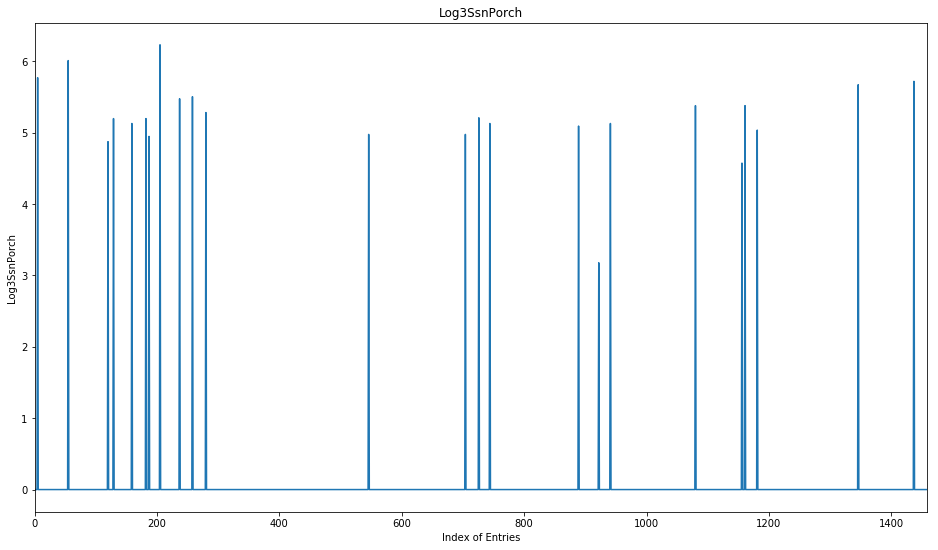

In [143]:
draw_figure(complete_train_data, 'Log3SsnPorch')

In [144]:
complete_train_data['Log3SsnPorch'].describe()

count    1460.000000
mean        0.085679
std         0.666876
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.232448
Name: Log3SsnPorch, dtype: float64

In [145]:
complete_train_data['Log3SsnPorch'].sort_values(ascending=False).head()

205     6.232448
55      6.011267
5       5.771441
1437    5.720312
1346    5.673323
Name: Log3SsnPorch, dtype: float64

Comment : There is some benefit and hence we are sticking with the log transform.

In [146]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, '3SsnPorch')

#### Column : ScreenPorch

In [147]:
complete_train_data['ScreenPorch'].unique()

array([  0, 176, 198, 291, 252,  99, 184, 168, 130, 142, 192, 410, 224,
       266, 170, 154, 153, 144, 128, 259, 160, 271, 234, 374, 185, 182,
        90, 396, 140, 276, 180, 161, 145, 200, 122,  95, 120,  60, 126,
       189, 260, 147, 385, 287, 156, 100, 216, 210, 197, 204, 225, 152,
       175, 312, 222, 265, 322, 190, 233,  63,  53, 143, 273, 288, 263,
        80, 163, 116, 480, 178, 440, 155, 220, 119, 165,  40])

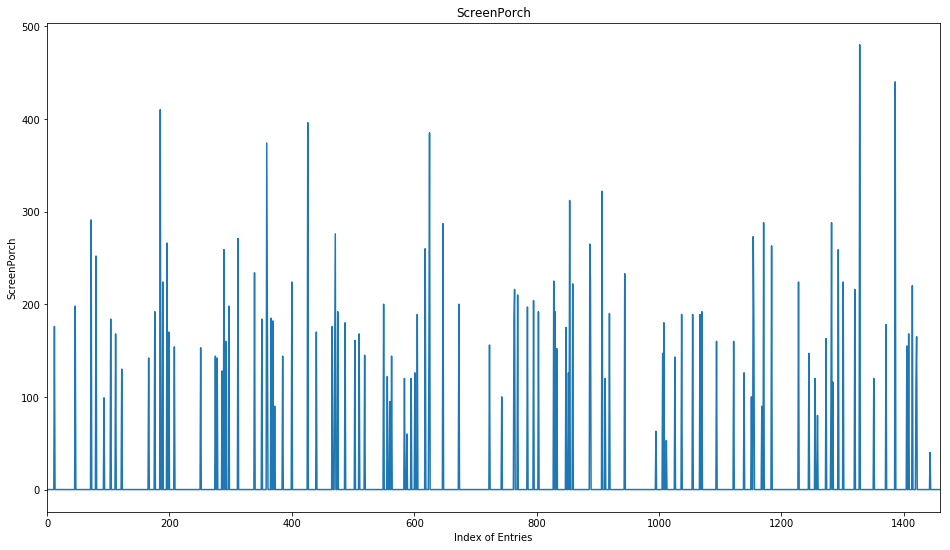

In [148]:
draw_figure(complete_train_data, 'ScreenPorch')

In [149]:
complete_train_data['ScreenPorch'].describe()

count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

Comment : Let us check out log transform here.

In [150]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'ScreenPorch', 'LogScreenPorch')

In [151]:
complete_train_data['LogScreenPorch'].describe()

count    1460.000000
mean        0.410671
std         1.403194
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.175867
Name: LogScreenPorch, dtype: float64

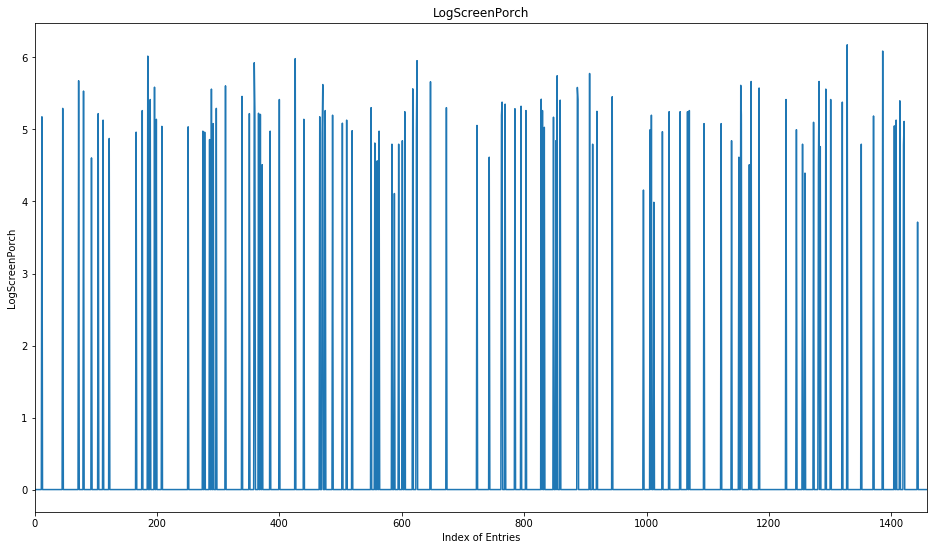

In [152]:
draw_figure(complete_train_data, 'LogScreenPorch')

Comment : We are keeping the transform here.

In [153]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'ScreenPorch')

#### Column : PoolArea

In [154]:
complete_train_data['PoolArea'].unique()

array([  0, 512, 648, 576, 555, 480, 519, 738])

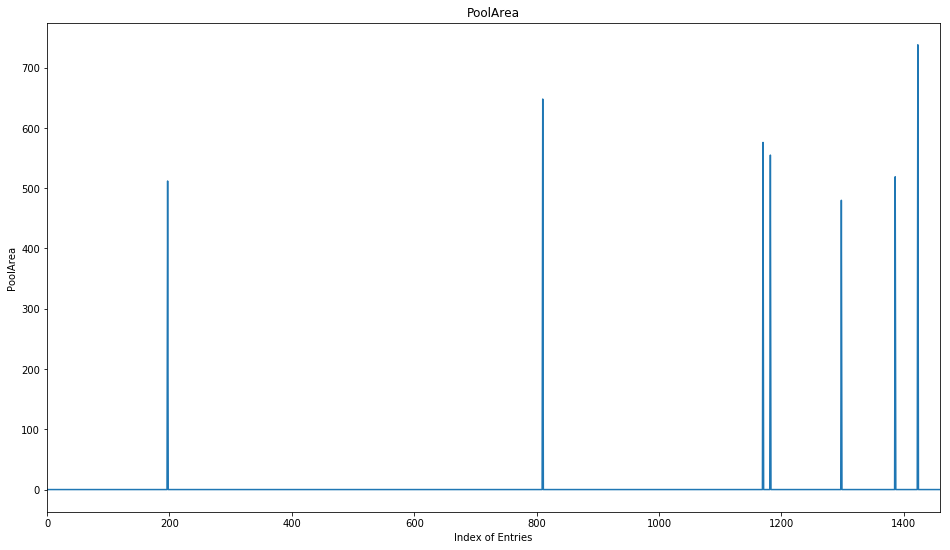

In [155]:
draw_figure(complete_train_data, 'PoolArea')

In [156]:
complete_train_data['PoolArea'].describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

Checking out log transform here.

In [157]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'PoolArea', 'LogPoolArea')

In [158]:
complete_train_data['LogPoolArea'].describe()

count    1460.000000
mean        0.030431
std         0.438685
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.605298
Name: LogPoolArea, dtype: float64

Comment : There is some benefit and hence we are sticking with the transform.

In [159]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'PoolArea')

#### Column : MiscVal

In [160]:
complete_train_data['MiscVal'].unique()

array([    0,   700,   350,   500,   400,   480,   450, 15500,  1200,
         800,  2000,   600,  3500,  1300,    54,   620,   560,  1400,
        8300,  1150,  2500])

In [161]:
complete_train_data['MiscVal'].describe()

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

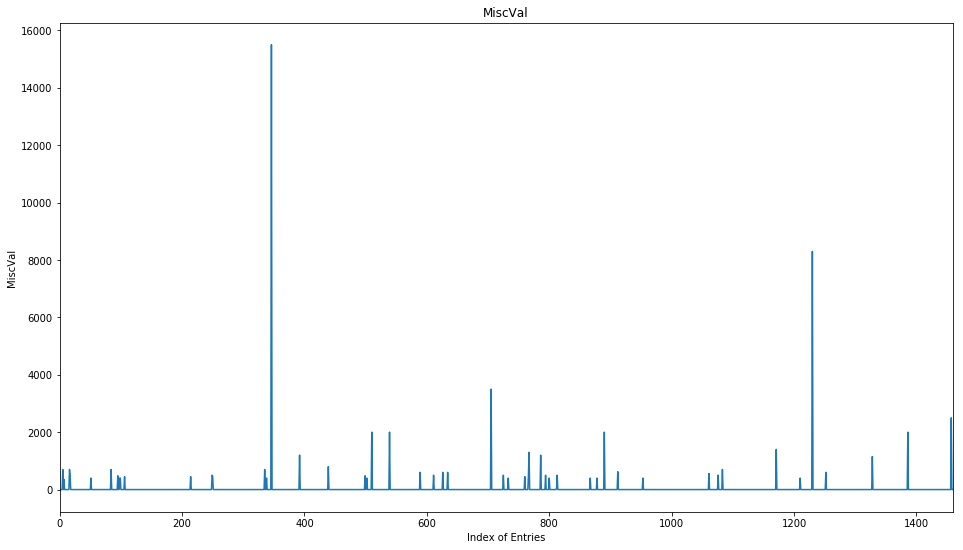

In [162]:
draw_figure(complete_train_data ,'MiscVal')

Comment : Looks like we can easily rein in extreme values using a log transform.

In [163]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'MiscVal', 'LogMiscVal')

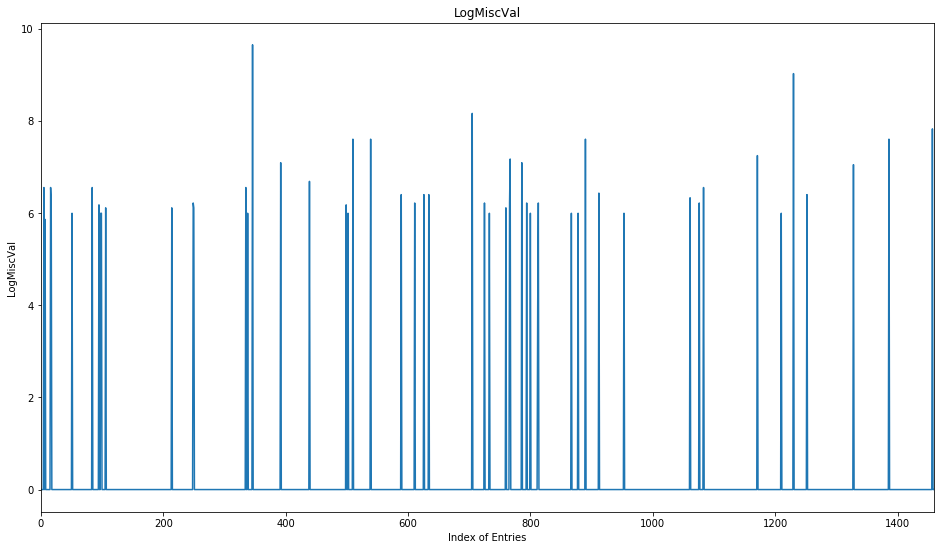

In [164]:
draw_figure(complete_train_data ,'LogMiscVal')

In [165]:
complete_train_data['LogMiscVal'].describe()

count    1460.000000
mean        0.233456
std         1.226030
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.648660
Name: LogMiscVal, dtype: float64

Comment : We definitely looked to have pulled down some extremums here. So, let us keep this transform

In [166]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'MiscVal')

#### Columns :  MoSold, YrSold

In [167]:
complete_train_data['MoSold'].describe()

count    1460.000000
mean        6.321918
std         2.703626
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64

In [168]:
complete_train_data['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6])

In [169]:
complete_train_data['YrSold'].unique()

array([2008, 2007, 2006, 2009, 2010])

Comment : Though we would see an increase in dimensionality, it makes perfect sense to keep these as categorical variables.

In [170]:
apply_transformation_both_train_and_test_data((lambda x : str(x)),
                                              complete_train_data, test_data,
                                              'MoSold', 'MoSold')

In [171]:
apply_transformation_both_train_and_test_data((lambda x : str(x)),
                                              complete_train_data, test_data,
                                              'YrSold', 'YrSold')

#### Column : SalePrice

In [172]:
complete_train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

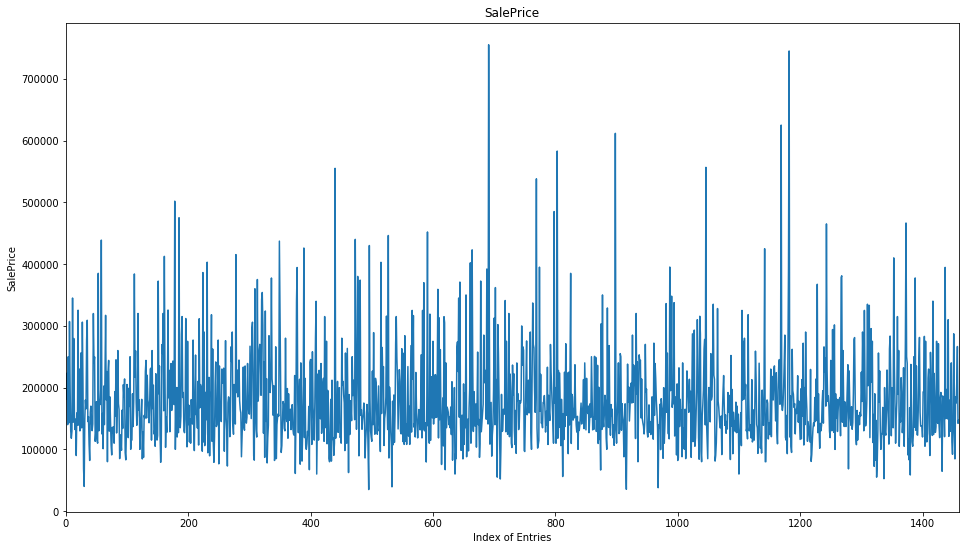

In [173]:
draw_figure(complete_train_data, 'SalePrice')

Comments : Looks like a log transform would be useful

In [174]:
# Do not do for test data , as we do not have this column in the SAM.
complete_train_data['LogSalePrice'] = complete_train_data['SalePrice'].apply(lambda x : np.log(x))


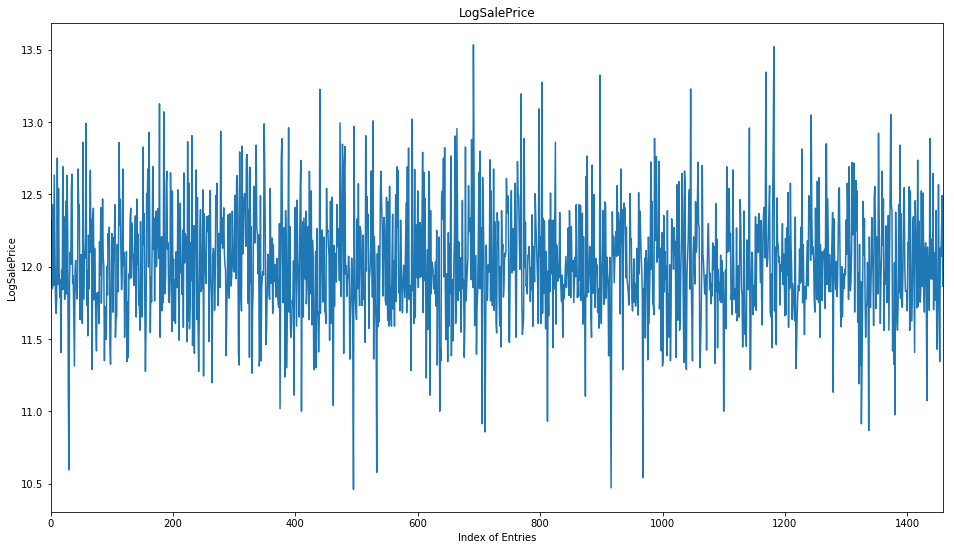

In [175]:
draw_figure(complete_train_data, 'LogSalePrice')

In [176]:
complete_train_data['LogSalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: LogSalePrice, dtype: float64

Comments : The values make a ton of sense now.

#### Columns  related to MasVnrArea

In [177]:
complete_train_data['MasVnrArea_times_not_missing'].describe()

count    1460.000000
mean      103.117123
std       180.731373
min         0.000000
25%         0.000000
50%         0.000000
75%       164.250000
max      1600.000000
Name: MasVnrArea_times_not_missing, dtype: float64

Comment : Since this is sort of a synthetic variable, let us check out the cases when this is 0, when MasVnrArea itself is  and when MasVnrArea is missing.

In [178]:
len(complete_train_data[(
    complete_train_data['MasVnrArea_times_not_missing']==0) & 
    (complete_train_data['MasVnrArea_not_missing'] == 1)])

861

In [179]:
len(complete_train_data[(
    complete_train_data['MasVnrArea_times_not_missing']==0) & 
    (complete_train_data['MasVnrArea_not_missing'] == 0)])

8

Now, that the values are in line with expectation, let us have a look at the raw data.

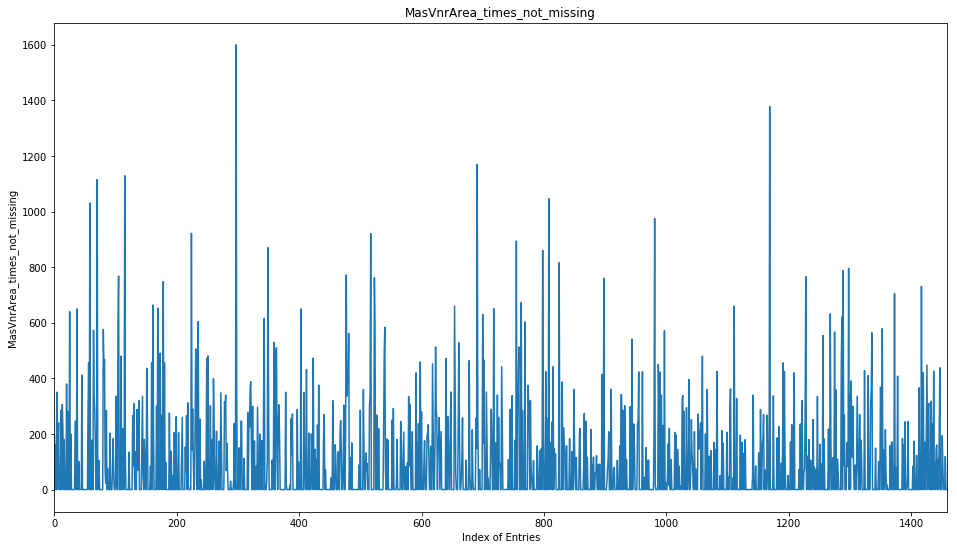

In [180]:
draw_figure(complete_train_data, 'MasVnrArea_times_not_missing')

In [181]:
complete_train_data['MasVnrArea_times_not_missing'].describe()

count    1460.000000
mean      103.117123
std       180.731373
min         0.000000
25%         0.000000
50%         0.000000
75%       164.250000
max      1600.000000
Name: MasVnrArea_times_not_missing, dtype: float64

In [182]:
complete_train_data['MasVnrArea_times_not_missing'].sort_values(ascending=False).head()

297     1600.0
1169    1378.0
691     1170.0
115     1129.0
70      1115.0
Name: MasVnrArea_times_not_missing, dtype: float64

Check out the log transform now.

In [183]:
apply_transformation_both_train_and_test_data(LOG_TRANSFORM,
                                              complete_train_data, test_data,
                                              'MasVnrArea_times_not_missing', 'LogMasVnrArea_times_not_missing')


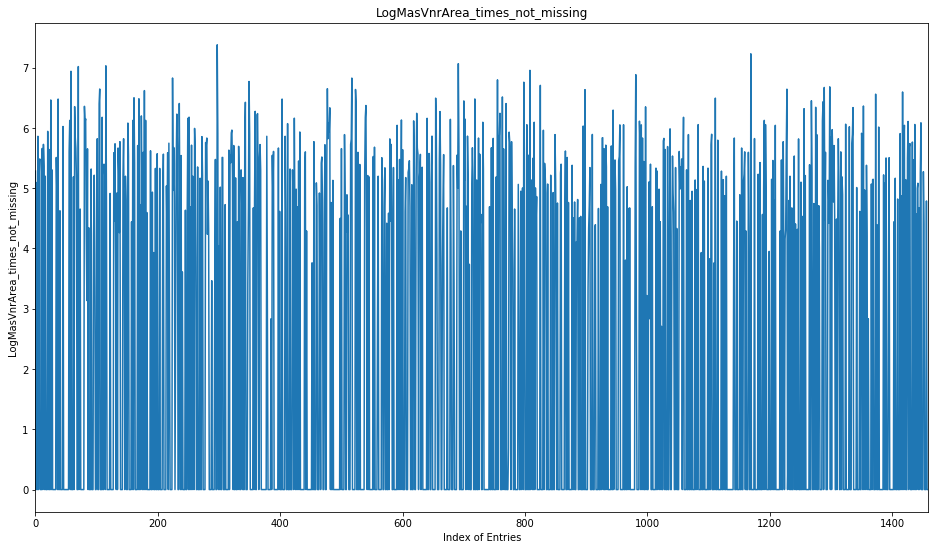

In [184]:
draw_figure(complete_train_data, 'LogMasVnrArea_times_not_missing')

In [185]:
complete_train_data['LogMasVnrArea_times_not_missing'].describe()

count    1460.000000
mean        2.120264
std         2.628759
min         0.000000
25%         0.000000
50%         0.000000
75%         5.107456
max         7.378384
Name: LogMasVnrArea_times_not_missing, dtype: float64

In [186]:
complete_train_data['LogMasVnrArea_times_not_missing'].sort_values(ascending=False)


297     7.378384
1169    7.229114
691     7.065613
115     7.029973
70      7.017506
808     6.954639
58      6.939254
981     6.883463
224     6.827629
517     6.826545
755     6.796824
349     6.769642
798     6.758095
825     6.705639
1298    6.680855
1289    6.670766
477     6.650279
105     6.645091
1228    6.642487
523     6.637258
898     6.634633
178     6.618739
1417    6.595781
1373    6.559615
763     6.513230
161     6.499787
654     6.493754
1111    6.493754
169     6.483107
718     6.480045
          ...   
893     0.000000
892     0.000000
890     0.000000
888     0.000000
887     0.000000
883     0.000000
882     0.000000
880     0.000000
878     0.000000
876     0.000000
875     0.000000
874     0.000000
873     0.000000
870     0.000000
845     0.000000
868     0.000000
867     0.000000
864     0.000000
863     0.000000
862     0.000000
861     0.000000
860     0.000000
857     0.000000
856     0.000000
855     0.000000
854     0.000000
852     0.000000
848     0.0000

Comment : We look to be having much less of a skewed distribution here. Therefore, we stick with the log transform.

In [187]:
#drop_column_both_train_and_test_data(complete_train_data, test_data, 'MasVnrArea_times_not_missing')

#### Columns related to GarageYrBlt

In [188]:
complete_train_data['GarageYrBlt_times_not_missing'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,    0., 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

One may question whether this should be regarded as categorical variable. That is a fair question, however because of the numerical nature of the variable and because of potential predictive power of values falling into a certain range, we are keeping it numeric for now.

In [189]:
complete_train_data[(complete_train_data['GarageYrBlt_times_not_missing'] != 0) & 
                    (complete_train_data['GarageYrBlt_times_not_missing'] != complete_train_data['YearBuilt'])]\
[['YearBuilt', 'GarageYrBlt_times_not_missing']]

YearBuilt  GarageYrBlt_times_not_missing
3          1915                         1998.0
15         1929                         1991.0
26         1951                         2005.0
27         2007                         2008.0
29         1927                         1920.0
36         1994                         1995.0
43         1975                         1977.0
51         1934                         1985.0
54         1955                         1962.0
59         1972                         1973.0
60         2004                         2006.0
61         1920                         1935.0
63         1921                         1990.0
64         1997                         1998.0
71         1982                         1987.0
73         1954                         1989.0
79         1910                         1966.0
83         1960                         1974.0
93         1910                         1900.0
104        1931                         1951.0
106        1885                         1954.0
117        2006                         2007.0
121        1939                         1979.0
126        1976                         1977.0
129        1958                         1998.0
132        1959                         1974.0
137        1988                         1989.0
142        1952                         2000.0
159        2005                         2006.0
170        1941                         1991.0
...         ...                            ...
1352       1937                         1999.0
1353       1995                         1996.0
1360       1921                         1998.0
1363       2006                         2007.0
1370       1920                         1967.0
1376       1930                         1925.0
1377       1941                         1977.0
1379       2006                         2007.0
1380       1914                         1938.0
1382       1920                         1989.0
1383       1918                         2007.0
1389       1941                         2003.0
1393       1905                         2003.0
1396       1948                         1966.0
1397       1920                         1933.0
1404       1915                         1998.0
1406       1972                         1988.0
1408       1910                         1966.0
1412       1949                         1956.0
1414       1923                         1922.0
1416       1885                         1971.0
1418       1963                         1962.0
1424       1958                         1970.0
1425       1959                         1960.0
1427       1945                         1962.0
1432       1927                         1928.0
1436       1971                         1974.0
1440       1922                         1993.0
1445       1966                         1990.0
1448       1910                         1950.0

[290 rows x 2 columns]

In [190]:
complete_train_data[(complete_train_data['GarageYrBlt_times_not_missing'] == 0) & 
                    (complete_train_data['GarageYrBlt_times_not_missing'] != complete_train_data['YearBuilt'])]\
[['YearBuilt', 'GarageYrBlt_times_not_missing']]

YearBuilt  GarageYrBlt_times_not_missing
39         1955                            0.0
48         1920                            0.0
78         1968                            0.0
88         1915                            0.0
89         1994                            0.0
99         1959                            0.0
108        1919                            0.0
125        1935                            0.0
127        1930                            0.0
140        1971                            0.0
148        2004                            0.0
155        1924                            0.0
163        1956                            0.0
165        1940                            0.0
198        1912                            0.0
210        1925                            0.0
241        1945                            0.0
250        1940                            0.0
287        1971                            0.0
291        1912                            0.0
307        1920                            0.0
375        1922                            0.0
386        1910                            0.0
393        1941                            0.0
431        1920                            0.0
434        1972                            0.0
441        1955                            0.0
464        1978                            0.0
495        1920                            0.0
520        1900                            0.0
...         ...                            ...
954        1975                            0.0
960        1958                            0.0
968        1910                            0.0
970        1949                            0.0
976        1923                            0.0
1009       1926                            0.0
1011       1965                            0.0
1030       1916                            0.0
1038       1970                            0.0
1096       1914                            0.0
1123       1947                            0.0
1131       1991                            0.0
1137       1875                            0.0
1143       1959                            0.0
1173       1946                            0.0
1179       1954                            0.0
1218       1947                            0.0
1219       1971                            0.0
1234       1911                            0.0
1257       1922                            0.0
1283       1971                            0.0
1323       1940                            0.0
1325       1922                            0.0
1326       1931                            0.0
1337       1941                            0.0
1349       1872                            0.0
1407       1985                            0.0
1449       1970                            0.0
1450       1974                            0.0
1453       2006                            0.0

[81 rows x 2 columns]

In [191]:
complete_train_data[(complete_train_data['GarageYrBlt_times_not_missing'] != 0)]\
[['YearBuilt', 'GarageYrBlt_times_not_missing']]

YearBuilt  GarageYrBlt_times_not_missing
0          2003                         2003.0
1          1976                         1976.0
2          2001                         2001.0
3          1915                         1998.0
4          2000                         2000.0
5          1993                         1993.0
6          2004                         2004.0
7          1973                         1973.0
8          1931                         1931.0
9          1939                         1939.0
10         1965                         1965.0
11         2005                         2005.0
12         1962                         1962.0
13         2006                         2006.0
14         1960                         1960.0
15         1929                         1991.0
16         1970                         1970.0
17         1967                         1967.0
18         2004                         2004.0
19         1958                         1958.0
20         2005                         2005.0
21         1930                         1930.0
22         2002                         2002.0
23         1976                         1976.0
24         1968                         1968.0
25         2007                         2007.0
26         1951                         2005.0
27         2007                         2008.0
28         1957                         1957.0
29         1927                         1920.0
...         ...                            ...
1427       1945                         1962.0
1428       1940                         1940.0
1429       1981                         1981.0
1430       2005                         2005.0
1431       1976                         1976.0
1432       1927                         1928.0
1433       2000                         2000.0
1434       1977                         1977.0
1435       1962                         1962.0
1436       1971                         1974.0
1437       2008                         2008.0
1438       1957                         1957.0
1439       1979                         1979.0
1440       1922                         1993.0
1441       2004                         2004.0
1442       2008                         2008.0
1443       1916                         1916.0
1444       2004                         2004.0
1445       1966                         1990.0
1446       1962                         1962.0
1447       1995                         1995.0
1448       1910                         1950.0
1451       2008                         2008.0
1452       2005                         2005.0
1454       2004                         2004.0
1455       1999                         1999.0
1456       1978                         1978.0
1457       1941                         1941.0
1458       1950                         1950.0
1459       1965                         1965.0

[1379 rows x 2 columns]

Comment : One option for us would be to use year built as a proxy for the year when the garage was built when the latter field was not available, but since we see that there are cases when the garage was built years later, we do not proceed further on it.

Hence, let us keep things as it is for now. 

Also, since values are rather sequential, we are not going for any transformations here.

In [192]:
len(complete_train_data.columns)

102

In [193]:
len(test_data.columns)

100

### Summary of data transformations.

Now, that we have come a long way (though we are yet to start building models), let us summarize the data transformations done so far (so that we do not get lost !):

1. The following columns were removed from the training as well as the test, because of a significant chunk of them being null value.

LotFrontage

Alley

FireplaceQu

PoolQC

Fence

MiscFeature




2. For the following categorical variables, null values are set to 'Missing' in both training as well as test data.

MasVnrType

BsmtQual

BsmtCond

BsmtExposure

BsmtFinType1

BsmtFinType2

Electrical

GarageType

GarageFinish

GarageQual

GarageCond

3. The action taken for every numeric column (including categorical columns BsmtFinType1 and BsmtFinType2) have been listed below :

MSSubClass : Stringified and made it a categorical variable.

LotArea : Did a log transform 

OverallQual : Nothing

OverallCond : Nothing

YearBuilt : Nothing

YearRemodAdd : Nothing

BsmtFinSF1 : Did a log transform

BsmtFinType1 : Missing values were set to Unf

BsmtFinSF2 : Did a log transform

BsmtFinType2 : Missing values were set to Unf

BsmtUnfSF : Did a log transform 

TotalBsmtSF : Did a log transform

1stFlrSF : Did a log transform 

2ndFlrSF : Did a log transform

LowQualFinSF : Did a log transform

GrLivArea : Did a log transform 
BsmtFullBath, BsmtHalfBath, FullBath, HalfBath : Nothing

BedroomAbvGr, KitchenAbvGr, Fireplaces, GarageCars¶ : Nothing

GarageArea : Did a log transform

WoodDeckSF : Did a log transform

OpenPorchSF : Did a log transform

EnclosedPorch : Did a log transform

3SsnPorch  : Did a log transform

ScreenPorch  : Did a log transform

MiscVal  : Did a log transform

MoSold,YrSold : Stringified and made it a categorical variable.

SalePrice : Did a log transform

MasVnrArea_times_not_missing : Did a log transform

GarageYrBlt_times_not_missing : Nothing




### Handling categorical variables in both train and test data.

Now, that we have handled numerical variables(and related transformations) in train and test data, we proceed to see how we could handle categorical variables in the same.

The trouble here is that test data may not contain all the values for a categorical variable that was found in train data and hence if we were to blindly do a one hot encoding on the train data, build a model and apply it on test data, this may not work (to make things worse , test data may contain some values that were not present in training data).

This is our proposal to get around this issue :

(a) Merge train and test data sets to one datagframe.

(b) Generate predictors for handing categorical variables by doing one hot encoding on this combined dataframe.

(c) Split training and test data frames from this combined data frame and proceed as usual.

Doing it this way, we ensure that one hot encoding is done on the combined data set and hence we will not be plagued by values of a categorical variable being present in one of the data sets and not present in the other.

In [194]:
# Bring dummy columns to facilitate  easy joining of 2 data frames.

In [195]:
test_data['SalePrice'] = -1
test_data['LogSalePrice'] = -10

In [196]:
complete_data = pd.concat([complete_train_data, test_data])

/Users/babs4JESUS/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [197]:
len(complete_train_data)

1460

In [198]:
len(test_data)

1459

In [199]:
complete_data_one_hot = pd.get_dummies(complete_data)

In [200]:
complete_train_data_one_hot = complete_data_one_hot[:(len(complete_train_data))]

In [201]:
test_data_one_hot = complete_data_one_hot[len(complete_train_data):]

In [202]:
len(complete_train_data_one_hot)

1460

#### Splitting into training and validation sets
Even though we will be using cross validation, we would still love to have another validation set to corroborate the results obtained through cross validation. 

This is helpful while comparing against other methods for which cross validation is not easily doable (say DNN's).

In [203]:
train_data_one_hot = complete_train_data_one_hot[:(1460 - 365)].copy()
validation_data_one_hot = complete_train_data_one_hot[(1460 - 365):].copy()
train_data = complete_train_data[:(1460 - 365)].copy()
validation_data = complete_train_data[(1460 - 365):].copy() 

In [204]:
len(test_data_one_hot)

1459

### Dumping all relevant dataframes to csv.

This way, we will ensure that all models have access to data, which has been cleaned and transformed.

In [205]:
# Dump alll the dataframes with one hot encoding.
train_data_one_hot.to_csv('../cleaned_input/train_data_one_hot.csv', index=False)
validation_data_one_hot.to_csv('../cleaned_input/validation_data_one_hot.to_csv', index=False)
test_data_one_hot.to_csv('../cleaned_input/test_data_one_hot.csv', index=False)

# Dump the data frames prior to taking the one hot encoding transformation.
# Remember that we had handled the null values at the stage and hence the model
# does not need to worry about the same.
train_data.to_csv('../cleaned_input/train_data.csv', index=False)
validation_data.to_csv('../cleaned_input/validation_data.csv', index=False)


In [208]:
test_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       ...
       'LogWoodDeckSF', 'LogOpenPorchSF', 'LogEnclosedPorch', 'Log3SsnPorch',
       'LogScreenPorch', 'LogPoolArea', 'LogMiscVal',
       'LogMasVnrArea_times_not_missing', 'SalePrice', 'LogSalePrice'],
      dtype='object', length=102)

In [210]:
test_data.drop(['SalePrice', 'LogSalePrice'], axis= 1, inplace=True)
test_data.to_csv('../cleaned_input/test.csv', index=False)